In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Set it to your desired number of threads
import missingno as msno
import shap

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

from IPython.display import display #To display dataframe with a nice format.

# Setting display precision for pandas
pd.set_option("display.precision", 2)
# Set display option to show all columns
pd.set_option('display.max_columns', None)

blue_green      = (82/255, 162/255, 160/255)
blue_green_dark = (41/255, 81/255, 81/255)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# ==================================================================================================
# Set the fontsize & Bold for each GRAPH !!!
# ==================================================================================================
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['axes.titlepad'] = 20 

In [2]:
import mlflow
from mlflow.tracking import MlflowClient
from pprint import pprint

mlflow.end_run()

client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

all_experiments = client.search_experiments()
print(all_experiments)

default_experiment = [
    {"name": experiment.name, "lifecycle_stage": experiment.lifecycle_stage}
    for experiment in all_experiments
    if experiment.name == "Default"
][0]

pprint(default_experiment)

[<Experiment: artifact_location='mlflow-artifacts:/435037538350658571', creation_time=1714568500251, experiment_id='435037538350658571', last_update_time=1714568500251, lifecycle_stage='active', name='P7_Models', tags={'mlflow.note.content': 'This is the supervised binary classifying of the bank '
                        'loan default/non default using XGBoost Model.',
 'project_name': 'Binary Loan forecasting (0 or 1)'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1714473625166, experiment_id='0', last_update_time=1714473625166, lifecycle_stage='active', name='Default', tags={}>]
{'lifecycle_stage': 'active', 'name': 'Default'}


In [3]:
# ==================================================================================================
# READ DATA
# ==================================================================================================
import csv

# Directory containing the CSV files
folder_path = r"C:\Users\Olivi\OneDrive\Documents\OC_Formation_DATA_SCIENCE\PROJET7_Implementez_un_modele_de_scoring\DATA"

# List of CSV files to read
csv_files = [
    "application_test.csv",
    "application_train.csv",
    "bureau.csv",
    "bureau_balance.csv",
    "credit_card_balance.csv",
    "HomeCredit_columns_description.csv",
    "installments_payments.csv",
    "POS_CASH_balance.csv",
    "previous_application.csv",
    "sample_submission.csv"
]



# Dictionary to store loaded DataFrames
dfs = {}

# Read each CSV file and store it in the dictionary
for file in csv_files:
    print(file)
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    dfs[file.replace('.csv', '')] = df

print("Datasets loaded successfully! :D")

df_application_test = dfs['application_test']
df_application_train = dfs['application_train']
df_bureau = dfs['bureau']
df_bureau_balance = dfs['bureau_balance']
df_credit_card_balance = dfs['credit_card_balance']
df_HomeCredit_columns_description = dfs['HomeCredit_columns_description']
df_installments_payments = dfs['installments_payments']
df_POS_CASH_balance = dfs['POS_CASH_balance']
df_previous_application = dfs['previous_application']
df_sample_submission = dfs['sample_submission']

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description.csv
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
sample_submission.csv
Datasets loaded successfully! :D


In [4]:
df_application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,4.07e+05,24700.5,3.51e+05,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1.88e-02,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08,0.26,0.14,0.02,0.04,0.97,0.62,1.43e-02,0.00,0.07,0.08,0.12,0.04,0.02,1.90e-02,0.00e+00,0.00e+00,0.03,0.04,0.97,0.63,1.44e-02,0.00,0.07,0.08,0.12,3.77e-02,0.02,1.98e-02,0.0,0.00,0.03,0.04,0.97,0.62,1.44e-02,0.00,0.07,0.08,0.12,0.04,0.02,1.93e-02,0.00e+00,0.00,reg oper account,block of flats,1.49e-02,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1.29e+06,35698.5,1.13e+06,Family,State servant,Higher education,Married,House / apartment,3.54e-03,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.31,0.62,NaN,0.10,0.05,0.99,0.80,6.05e-02,0.08,0.03,0.29,0.33,0.01,0.08,5.49e-02,3.90e-03,9.80e-03,0.09,0.05,0.99,0.80,4.97e-02,0.08,0.03,0.29,0.33,1.28e-02,0.08,5.54e-02,0.0,0.00,0.10,0.05,0.99,0.80,6.08e-02,0.08,0.03,0.29,0.33,0.01,0.08,5.58e-02,3.90e-03,0.01,reg oper account,block of flats,7.14e-02,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,1.35e+05,6750.0,1.35e+05,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1.00e-02,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.56,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0

# I. EDA

TARGET
0    282686
1     24825
Name: count, dtype: int64

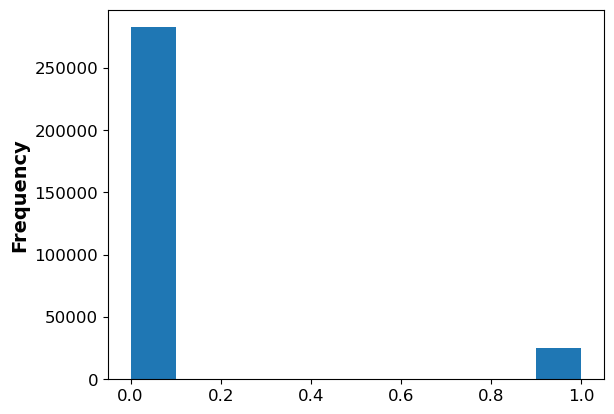

In [5]:
# ==================================================================================================
# Examine the Distribution of the Target Column¶
# ==================================================================================================
display(df_application_train['TARGET'].value_counts())
df_application_train['TARGET'].astype(int).plot.hist();

In [6]:
# ==================================================================================================
# MISSING VALUES
# ==================================================================================================
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(df_application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [7]:
# ==================================================================================================
# CATEGORICAL FEATURES
# ==================================================================================================
# Number of unique classes in each object column
df_application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [8]:
# ==================================================================================================
# CATEGORICAL FEATURES - ENCODING
# LABEL ENCODING (NB category <= 2)
# ONE HOT ENCODING (NB category > 2)
#
# In this notebook, we will use Label Encoding for any categorical variables with only 2 categories 
# and One-Hot Encoding for any categorical variables with more than 2 categories.
# ==================================================================================================

# === I. LABEL ENCODER ===
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df_application_train:
    if df_application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df_application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(df_application_train[col])
            # Transform both training and testing data
            df_application_train[col] = le.transform(df_application_train[col])
            df_application_test[col] = le.transform(df_application_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# === II. ONE HOT ENCODER ===
# one-hot encoding of categorical variables
df_application_train = pd.get_dummies(df_application_train)
df_application_test = pd.get_dummies(df_application_test)

print('Training Features shape: ', df_application_train.shape)
print('Testing Features shape: ', df_application_test.shape)

3 columns were label encoded.
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [9]:
# ==================================================================================================
# ALIGNING TRAINING AND TESTTING DATA
#
# There need to be the same features (columns) in both the training and testing data. 
# One-hot encoding has created more columns in the training data because there were some categorical 
# variables with categories not represented in the testing data. To remove the columns in the 
# training data that are not in the testing data, we need to align the dataframes. 
# First we extract the target column from the training data (because this is not in the testing 
# data but we need to keep this information). When we do the align, we must make sure to set 
# axis = 1 to align the dataframes based on the columns and not on the rows!
# ==================================================================================================
train_labels = df_application_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_application_train, df_application_test = df_application_train.align(df_application_test, join = 'inner', axis = 1)

# Add the target back in
df_application_train['TARGET'] = train_labels

print('Training Features shape: ', df_application_train.shape)
print('Testing Features shape: ', df_application_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


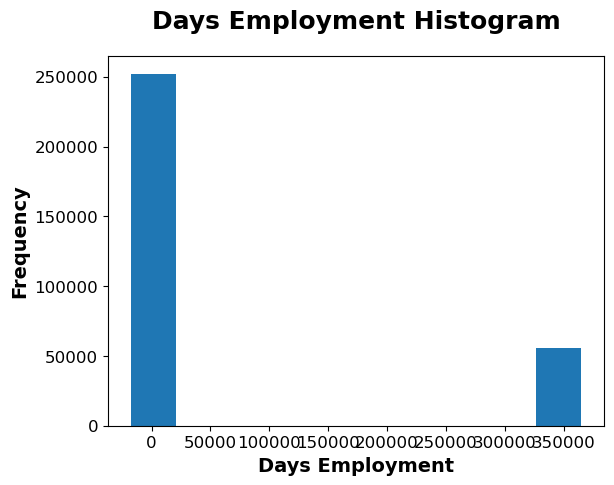

In [10]:
# ==================================================================================================
# DATA ANOMALIES
# ==================================================================================================
df_application_train['DAYS_EMPLOYED'].describe()
df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [11]:
anom = df_application_train[df_application_train['DAYS_EMPLOYED'] == 365243]
non_anom = df_application_train[df_application_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


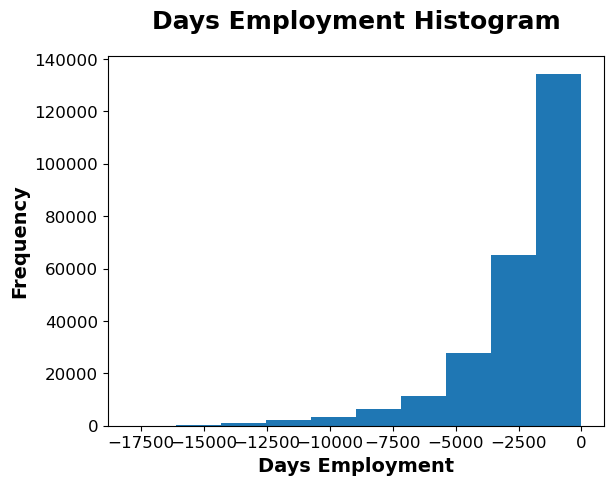

In [12]:
# Create an anomalous flag column
df_application_train['DAYS_EMPLOYED_ANOM'] = df_application_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

df_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [13]:
df_application_test['DAYS_EMPLOYED_ANOM'] = df_application_test["DAYS_EMPLOYED"] == 365243
df_application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_application_test["DAYS_EMPLOYED_ANOM"].sum(), len(df_application_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [14]:
# ==================================================================================================
# CORRELATIONS
# .00-.19 “very weak”
# .20-.39 “weak”
# .40-.59 “moderate”
# .60-.79 “strong”
# .80-1.0 “very strong”
# ==================================================================================================
# Find correlations with the target and sort
correlations = df_application_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.04
FLAG_DOCUMENT_3                                      0.04
REG_CITY_NOT_LIVE_CITY                               0.04
FLAG_EMP_PHONE                                       0.05
NAME_EDUCATION_TYPE_Secondary / secondary special    0.05
REG_CITY_NOT_WORK_CITY                               0.05
DAYS_ID_PUBLISH                                      0.05
CODE_GENDER_M                                        0.05
DAYS_LAST_PHONE_CHANGE                               0.06
NAME_INCOME_TYPE_Working                             0.06
REGION_RATING_CLIENT                                 0.06
REGION_RATING_CLIENT_W_CITY                          0.06
DAYS_EMPLOYED                                        0.07
DAYS_BIRTH                                           0.08
TARGET                                               1.00
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.

-0.07823930830982712

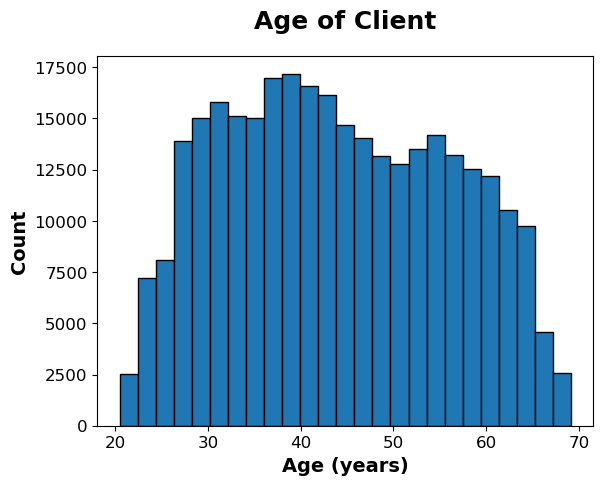

In [15]:
# Find the correlation of the positive days since birth and target
df_application_train['DAYS_BIRTH'] = abs(df_application_train['DAYS_BIRTH'])
display(df_application_train['DAYS_BIRTH'].corr(df_application_train['TARGET']))

# Plot the distribution of ages in years
plt.hist(df_application_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

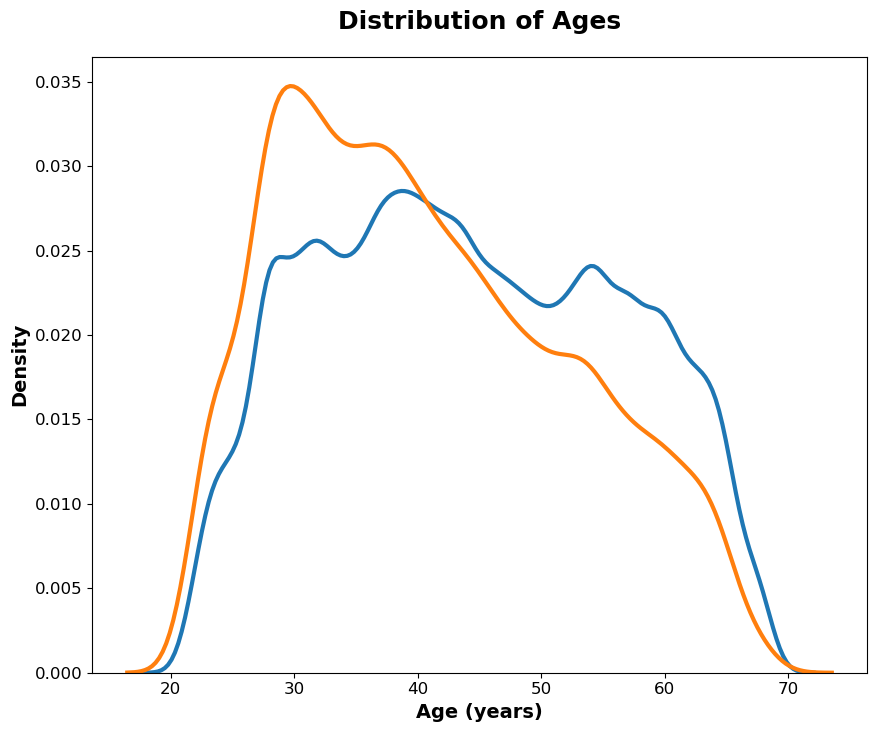

In [16]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.12,8532.80,23.38
"(25.0, 30.0]",0.11,10155.22,27.82
"(30.0, 35.0]",0.10,11854.85,32.48
"(35.0, 40.0]",0.09,13707.91,37.56
"(40.0, 45.0]",0.08,15497.66,42.46
"(45.0, 50.0]",0.07,17323.90,47.46
"(50.0, 55.0]",0.07,19196.49,52.59
"(55.0, 60.0]",0.06,20984.26,57.49
"(60.0, 65.0]",0.05,22780.55,62.41


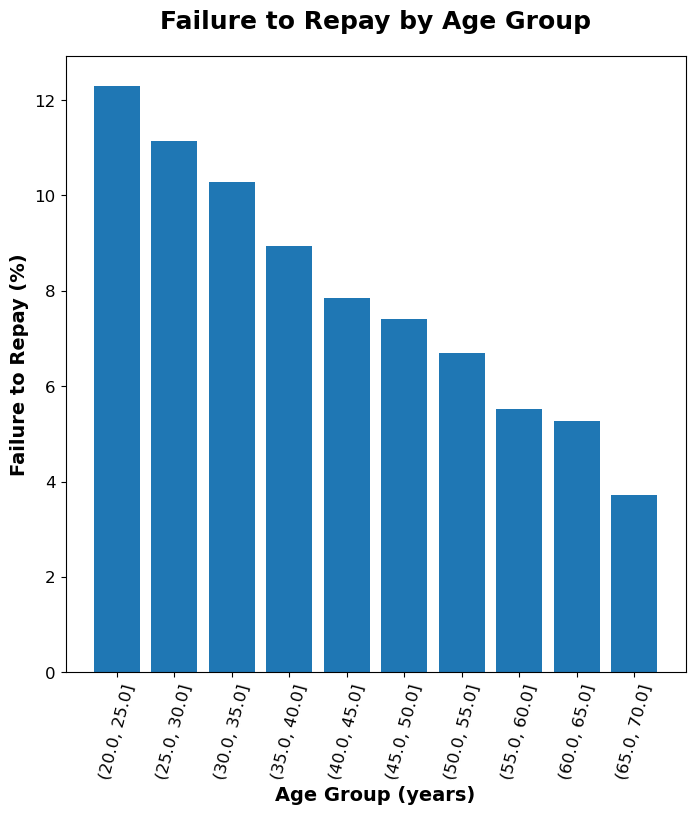

In [17]:
# Age information into a separate dataframe
age_data = df_application_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
display(age_groups)

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

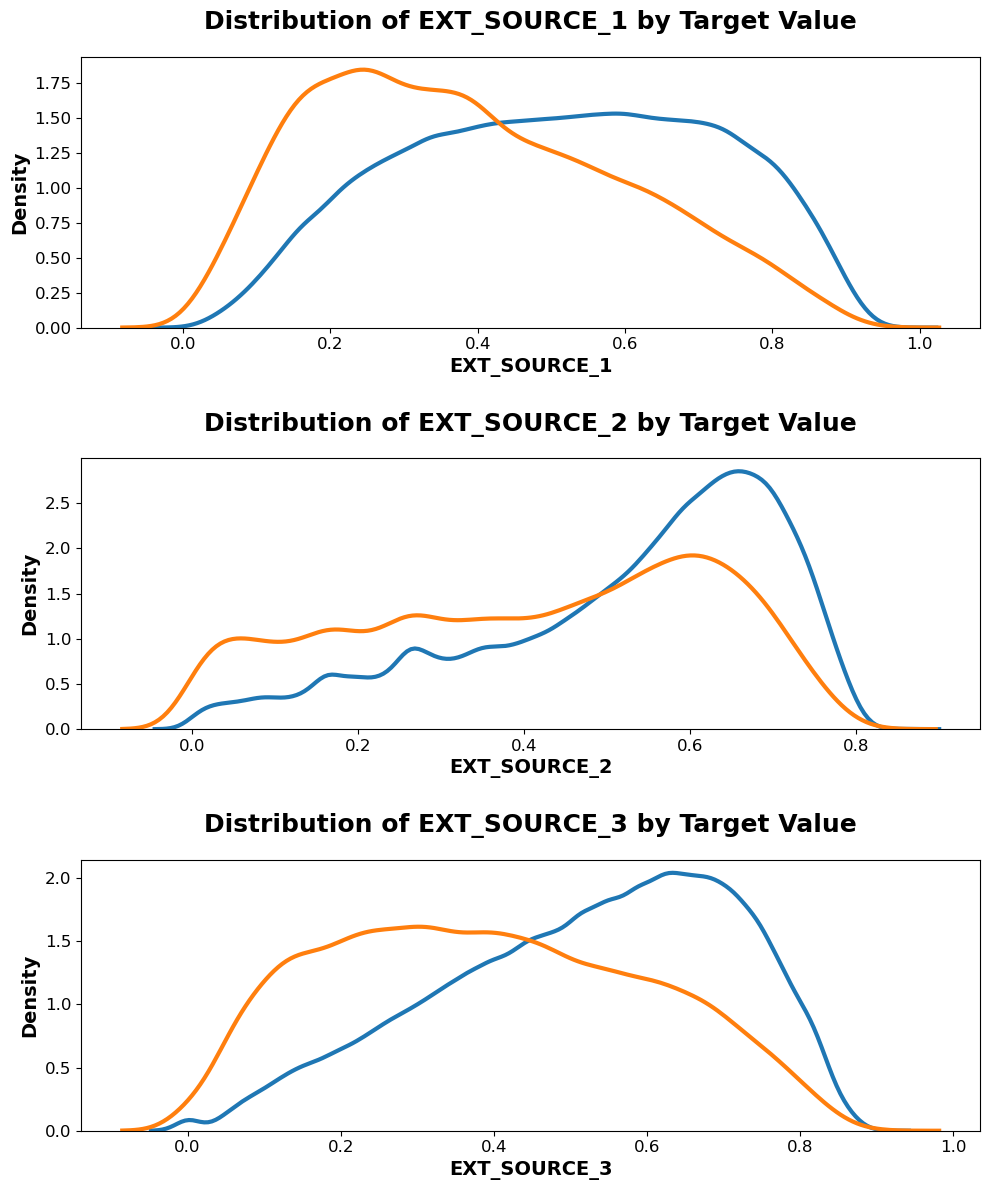

In [18]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

In [19]:
# Make a new dataframe for polynomial features
poly_features = df_application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = df_application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [20]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [21]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [22]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.19
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.19
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.18
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.18
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.17
EXT_SOURCE_1 EXT_SOURCE_2                -0.17
EXT_SOURCE_1 EXT_SOURCE_3                -0.16
EXT_SOURCE_2                             -0.16
EXT_SOURCE_2 DAYS_BIRTH                  -0.16
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.16
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.08
DAYS_BIRTH^2   -0.08
DAYS_BIRTH^3   -0.07
TARGET          1.00
1                NaN
Name: TARGET, dtype: float64


In [23]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = df_application_train['SK_ID_CURR']
df_application_train_poly = df_application_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')



# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = df_application_test['SK_ID_CURR']
df_application_test_poly = df_application_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
df_application_train_poly, df_application_test_poly = df_application_train_poly.align(df_application_test_poly, join = 'inner', axis = 1)

# Merge 'TARGET' column back into df_application_train_poly
df_application_train_poly['TARGET'] = df_application_train['TARGET']

# Print out the new shapes
print('Training data with polynomial features shape: ', df_application_train_poly.shape)
print('Testing data with polynomial features shape:  ', df_application_test_poly.shape)

Training data with polynomial features shape:  (307511, 276)
Testing data with polynomial features shape:   (48744, 275)


In [24]:
df_application_train_poly['TARGET']

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

In [25]:
df_application_train_domain = df_application_train.copy()
df_application_test_domain = df_application_test.copy()

df_application_train_domain['CREDIT_INCOME_PERCENT'] = df_application_train_domain['AMT_CREDIT'] / df_application_train_domain['AMT_INCOME_TOTAL']
df_application_train_domain['ANNUITY_INCOME_PERCENT'] = df_application_train_domain['AMT_ANNUITY'] / df_application_train_domain['AMT_INCOME_TOTAL']
df_application_train_domain['CREDIT_TERM'] = df_application_train_domain['AMT_ANNUITY'] / df_application_train_domain['AMT_CREDIT']
df_application_train_domain['DAYS_EMPLOYED_PERCENT'] = df_application_train_domain['DAYS_EMPLOYED'] / df_application_train_domain['DAYS_BIRTH']

df_application_test_domain['CREDIT_INCOME_PERCENT'] = df_application_test_domain['AMT_CREDIT'] / df_application_test_domain['AMT_INCOME_TOTAL']
df_application_test_domain['ANNUITY_INCOME_PERCENT'] = df_application_test_domain['AMT_ANNUITY'] / df_application_test_domain['AMT_INCOME_TOTAL']
df_application_test_domain['CREDIT_TERM'] = df_application_test_domain['AMT_ANNUITY'] / df_application_test_domain['AMT_CREDIT']
df_application_test_domain['DAYS_EMPLOYED_PERCENT'] = df_application_test_domain['DAYS_EMPLOYED'] / df_application_test_domain['DAYS_BIRTH']

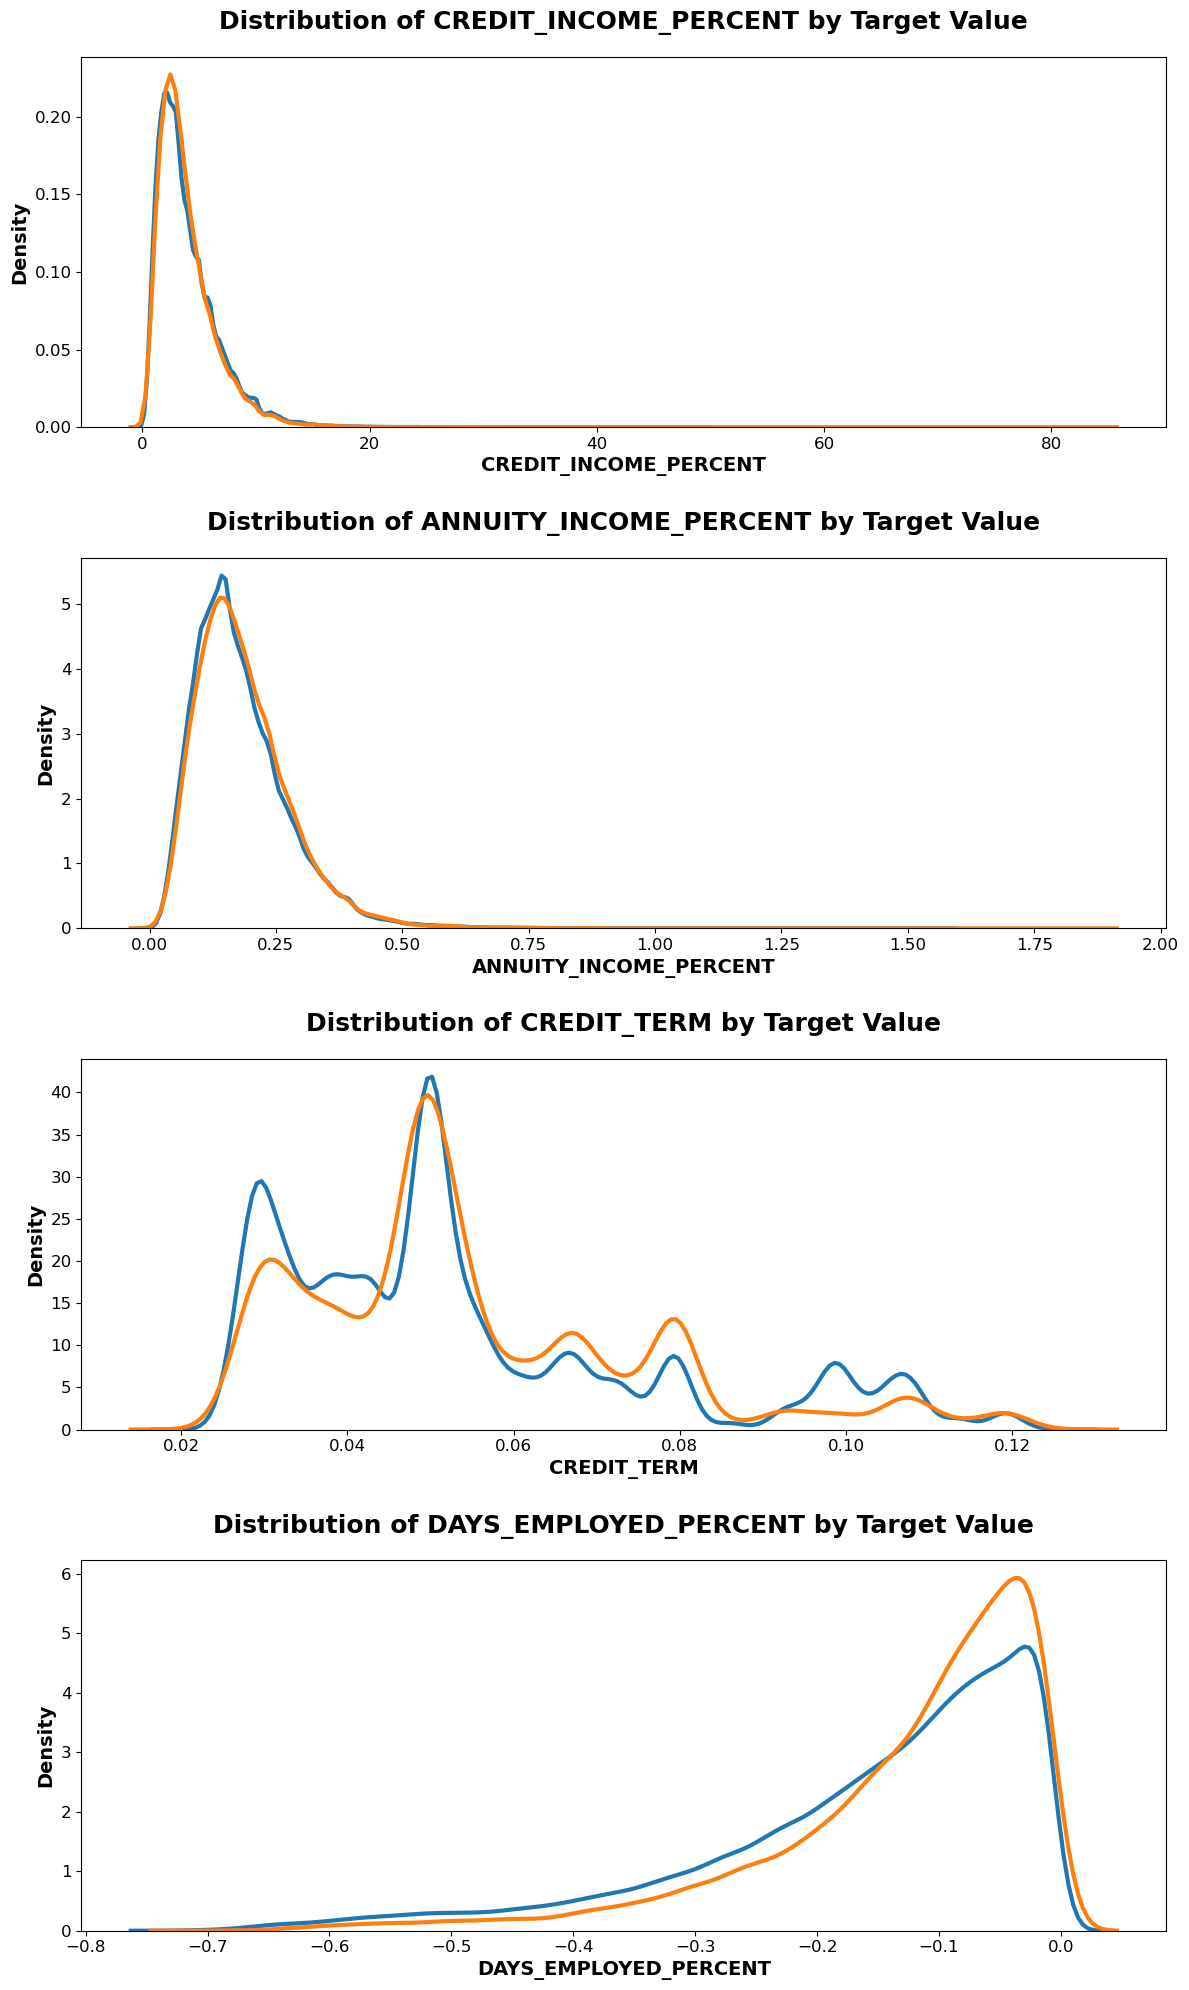

In [26]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_application_train_domain.loc[df_application_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_application_train_domain.loc[df_application_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

NOTE:
It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

# II. DATA PREPROCESSING

In [27]:
# ==================================================================================================
# DATA PREPROCESSING
# ==================================================================================================
# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [28]:
# # # ==================================================================================================
# # # DATA PREPROCESSING
# # # ==================================================================================================
# def preprocess_dataframe(df):
#     # Define features and target variable
#     X = df.drop(columns=['TARGET'])
#     y = df['TARGET']

#     # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Preprocessing for numerical features
#     numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
#     numerical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler())])

#     # Preprocessing for categorical features
#     categorical_features = X.select_dtypes(include=['object']).columns
#     categorical_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#     # Combine preprocessing steps
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numerical_transformer, numerical_features),
#             ('cat', categorical_transformer, categorical_features)])

#     return preprocessor, X_train, y_train, X_test, y_test

# # Example usage:
# # preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train)


In [29]:
# # ==================================================================================================
# # DATA PREPROCESSING
# # ==================================================================================================
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split


def preprocess_dataframe(df):
    # Define features and target variable
    X = df.drop(columns=['TARGET'])
    y = df['TARGET']

    # Convert boolean features to integer
    bool_cols = X.select_dtypes(include=['bool']).columns
    X[bool_cols] = X[bool_cols].astype(int)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocessing for numerical features
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    # Preprocessing for categorical features
    categorical_features = X.select_dtypes(include=['object']).columns
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor, X_train, y_train, X_test, y_test

# III. TARGET PREDICTION AND RESULTS SAVED USING MLFLOW

In [30]:
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities.experiment import Experiment

# Set tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Initialize the MLflow client
client = MlflowClient()

# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the supervised binary classifying of the bank loan default/non default using XGBoost Model."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "Binary Loan forecasting (0 or 1)",
    "mlflow.note.content": experiment_description,
}

# Check if the experiment already exists
experiment_name = "P7_Models"
existing_experiment = client.get_experiment_by_name(experiment_name)

if existing_experiment:
    print(f"Experiment '{experiment_name}' already exists. Using existing experiment.")
    experiment_id = existing_experiment.experiment_id
else:
    # Create the Experiment, providing a unique name
    experiment_id = client.create_experiment(
        name=experiment_name, tags=experiment_tags
    )


Experiment 'P7_Models' already exists. Using existing experiment.


In [31]:
'''
Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) 
et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)

Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
Vous créerez un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le 
meilleur modèle et ses meilleurs hyperparamètres. Attention cette minimisation du coût métier doit passer par l’optimisation du seuil 
qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)
'''
def calculate_business_metric(y_true, y_pred_proba, cost_fn, cost_fp, threshold):
    """
    Calculate the total business cost based on the predictions and true labels, considering the imbalance in the cost of false negatives (FN) and false positives (FP).

    Parameters:
    - y_true (array-like): True binary labels. Each element indicates whether the corresponding sample belongs to the positive class (1) or the negative class (0).
    - y_pred_proba (array-like): Predicted probabilities for the positive class.
    - cost_fn (float): Cost associated with each false negative (FN). This represents the financial loss incurred when a negative instance is incorrectly classified as positive.
    - cost_fp (float): Cost associated with each false positive (FP). This represents the financial loss incurred when a positive instance is incorrectly classified as negative.
    - threshold (float): Threshold for classification. Probabilities above this threshold are classified as positive, while those below are classified as negative.

    Returns:
    - total_cost (float): Total cost calculated based on the business metric. The total cost is computed as the sum of the costs of false negatives (FN) and false positives (FP).

    Example:
    Consider the following scenario:
    - True labels (y_true): [1, 0, 1, 0, 0]
    - Predicted probabilities for the positive class (y_pred_proba): [0.8, 0.3, 0.4, 0.9, 0.2]
    - Cost of false negatives (cost_fn): $10
    - Cost of false positives (cost_fp): $1
    - Classification threshold (threshold): 0.5

    Using these inputs, let's calculate the total business cost:
    - For the first sample, the true label is 1 (positive), and the predicted probability is 0.8, which is above the threshold. Hence, it's correctly classified as positive.
    - For the second sample, the true label is 0 (negative), but the predicted probability is 0.3, which is below the threshold. Hence, it's correctly classified as negative.
    - For the third sample, the true label is 1 (positive), and the predicted probability is 0.4, which is below the threshold. Hence, it's incorrectly classified as positive (false positive).
    - For the fourth sample, the true label is 0 (negative), and the predicted probability is 0.9, which is above the threshold. Hence, it's incorrectly classified as positive (false negative).
    - For the fifth sample, the true label is 0 (negative), but the predicted probability is 0.2, which is below the threshold. Hence, it's incorrectly classified as positive.

    Based on these classifications and costs, the total business cost is calculated as follows:
    - Cost of false negatives: 1 * $100 = $100
    - Cost of false positives: 1 * $10  = $10
    - Total cost = $100 + $10 = $110

    Therefore, the total business cost for this scenario is $110.
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    fn_cost = (y_true & ~y_pred).sum() * cost_fn
    fp_cost = (~y_true & y_pred).sum() * cost_fp
    total_cost = fn_cost + fp_cost
    return total_cost

def calculate_shap_values(model, preprocessor, X_train_transformed, X_test_transformed):
    # Initialize the SHAP explainer with the model and training data
    explainer = shap.Explainer(model, X_train_transformed)

    # Calculate SHAP values for the test data
    shap_values = explainer(X_test_transformed)

    return shap_values
    
def run_mlflow_experiment(model, preprocessor, X_train, y_train, X_test, y_test, run_name, description, experiment_name="MLflow_Experiment", threshold=0.5, cost_fn=10, cost_fp=1, b_displaySHAP=False):
    """
    Runs an MLflow experiment to train a machine learning model, evaluate its performance 
    using various metrics including accuracy, precision, recall, F1-score, ROC-AUC, and 
    the business-specific cost metric, and logs the results along with model parameters 
    and evaluation metrics.

    Args:
    - model: The machine learning model to use.
    - preprocessor: The data preprocessor (e.g., a preprocessing pipeline).
    - X_train, y_train: The training data and labels.
    - X_test, y_test: The test data and labels.
    - run_name: Name of the MLflow run.
    - experiment_name: Name of the MLflow experiment. Default is "MLflow_Experiment".
    - threshold: Threshold for classification (default is 0.5).
    - cost_fn: Cost of false negatives (default is 10).
    - cost_fp: Cost of false positives (default is 1).
    
    Returns:
    - total_cost: Total cost based on the business metric.
    """
    # Start MLflow experiment
    mlflow.set_experiment(experiment_name)

    # Define the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    with mlflow.start_run(run_name=run_name, tags={"description": description}) as run:

        # ********************************************
        # LOG DATASET
        # ********************************************
        mlflow.log_input(from_pandas(X_train, name='my_dataset'))

        # ********************************************
        # Train the model
        # ********************************************
        print("Training the model...")
        pipeline.fit(X_train, y_train)
        print("Model training completed.")

        # Log the model parameters
        mlflow.log_params(model.get_params())
        
        # Log the threshold value
        mlflow.log_param("threshold", threshold)
        mlflow.log_param("cost_fn", cost_fn)
        mlflow.log_param("cost_fp", cost_fp)

        
        # ********************************************
        # Make predictions
        # ********************************************
        print("Making predictions...")
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        # Make predictions based on the threshold
        y_pred = (y_pred_proba >= threshold).astype(int)
        print("Predictions made.")
        

        # ********************************************
        # Calculate ROC curve, Find optimal threshold 
        # based on ROC curve and Calculate total cost 
        # at optimal threshold
        # ********************************************
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

        # Calculate AUC-ROC
        auc_roc = roc_auc_score(y_test, y_pred_proba)

        # Find optimal threshold based on ROC curve
        optimal_threshold_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_idx]
        # Make predictions based on the optimal threshold
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
        
        # Calculate total cost at optimal threshold
        total_cost_optimal = calculate_business_metric(y_test, y_pred_optimal, cost_fn, cost_fp, optimal_threshold)

        # Log optimal threshold and total cost at optimal threshold
        mlflow.log_metric(".optimal_threshold", optimal_threshold)
        mlflow.log_metric(".total_cost_optimal", total_cost_optimal)

        print(f'Optimal Threshold: {optimal_threshold}')
        print(f'Total Cost at Optimal Threshold: {total_cost_optimal}')

        # Print ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_roc:.2f}')
        plt.scatter(fpr[optimal_threshold_idx], tpr[optimal_threshold_idx], marker='o', color='red', label=f'Optimal Threshold ({optimal_threshold:.2f})')
        # Add vertical line
        plt.axvline(x=fpr[optimal_threshold_idx], color='red', linestyle='--')
        # Add horizontal line
        plt.axhline(y=tpr[optimal_threshold_idx], color='red', linestyle='--')

        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.savefig("roc_curve.png")
        plt.show()
        mlflow.log_artifact("roc_curve.png")

        mlflow.log_metric(".auc_roc", auc_roc)


        # ********************************************
        # Calculate accuracy score
        # ********************************************
        accuracy = accuracy_score(y_test, y_pred_optimal)
        #Log evaluation metrics
        mlflow.log_metric("accuracy", accuracy)


        # ********************************************
        # Calculate precision-recall curve
        # ********************************************
        precision, recall, _ = precision_recall_curve(y_test, y_pred_optimal)

        # Plot precision-recall curve
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        plt.savefig("precision_recall_curve.png")
        plt.show()
        mlflow.log_artifact("precision_recall_curve.png")


        # ********************************************
        # Classification report
        # ********************************************
        print("Classification Report:")
        print(classification_report(y_test, y_pred_optimal))
        classification_rep = classification_report(y_test, y_pred_optimal, output_dict=True)
        precision_0 = classification_rep['0']['precision']
        recall_0 = classification_rep['0']['recall']
        f1_score_0 = classification_rep['0']['f1-score']
        precision_1 = classification_rep['1']['precision']
        recall_1 = classification_rep['1']['recall']
        f1_score_1 = classification_rep['1']['f1-score']
        # Log individual metrics
        mlflow.log_metric("precision_0", precision_0)
        mlflow.log_metric("recall_0", recall_0)
        mlflow.log_metric("f1_score_0", f1_score_0)
        mlflow.log_metric("precision_1", precision_1)
        mlflow.log_metric("recall_1", recall_1)
        mlflow.log_metric("f1_score_1", f1_score_1)


        # ********************************************
        # Confusion Matrix
        # ********************************************
        # Log confusion matrix as an artifact
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred_optimal))
        confusion_mat_str = str(confusion_matrix(y_test, y_pred_optimal))
        # Log confusion matrix as an artifact
        with open("confusion_matrix.txt", "w") as f:
            f.write(confusion_mat_str)
        mlflow.log_artifact("confusion_matrix.txt")

        # Save the model
        mlflow.sklearn.log_model(pipeline, "model")

        # ********************************************
        # Feature Importance Analysis
        # ********************************************
        if b_displaySHAP == True : 
            # # Get feature importances
            # if hasattr(model, 'feature_importances_'):
            #     importances = model.feature_importances_
            # else:
            #     importances = np.abs(model.coef_[0])
    
            # # Sort feature importances in descending order
            # indices = np.argsort(importances)[::-1]
    
            # # Log feature importances
            # for f in range(X_train.shape[1]):
            #     mlflow.log_metric(f"feature_importance_{f+1}", importances[indices[f]], step=f)
    
            # # Plot the feature importances
            # plt.figure(figsize=(10, 6))
            # plt.title("Feature Importances")
            # plt.bar(range(X_train.shape[1]), importances[indices], align="center")
            # plt.xticks(range(X_train.shape[1]), indices)
            # plt.xlim([-1, X_train.shape[1]])
            # plt.xlabel("Feature index")
            # plt.ylabel("Feature importance")
            # plt.savefig("feature_importance.png")
            # plt.show()
            # mlflow.log_artifact("feature_importance.png")
    
            # Calculate SHAP values
            shap_values = calculate_shap_values(model, preprocessor, X_train, X_test)
            
            # Plot SHAP summary plot
            shap.summary_plot(shap_values, X_test, plot_type="bar")
            plt.savefig("shap_feature_importance.png")
            mlflow.log_artifact("shap_feature_importance.png")



In [32]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import precision_recall_curve


from sklearn.metrics import accuracy_score  # Add this import statement
from sklearn.metrics import classification_report  # Add this import statement
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc


from datetime import datetime



## III.1. TEST 1 - df_application_train

Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.45613226294517517
Total Cost at Optimal Threshold: 33983


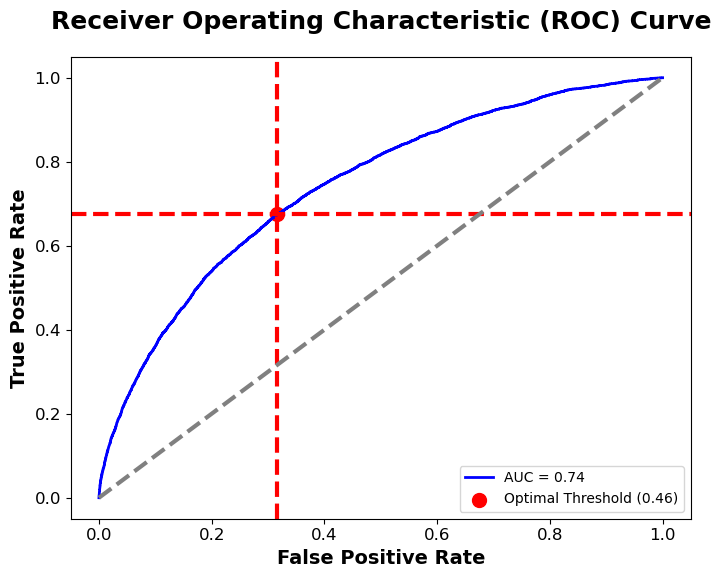

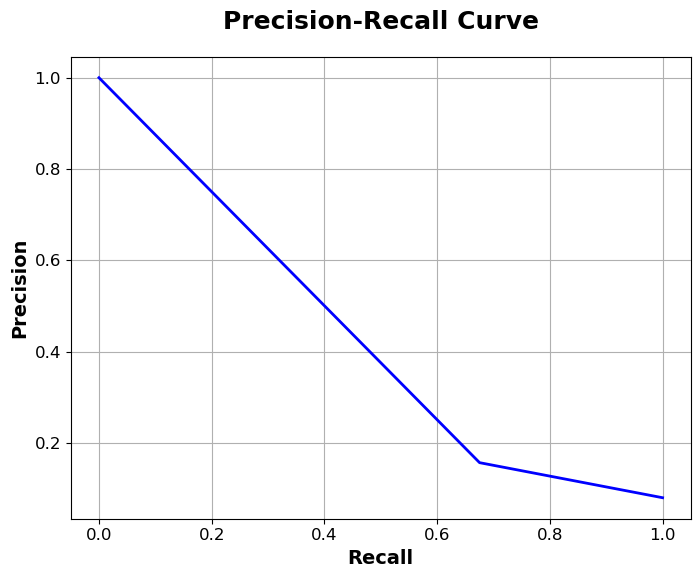

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56554
           1       0.16      0.68      0.26      4949

    accuracy                           0.68     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.68      0.75     61503

Confusion Matrix:
[[38641 17913]
 [ 1607  3342]]


100%|===================| 61352/61503 [01:32<00:00]        

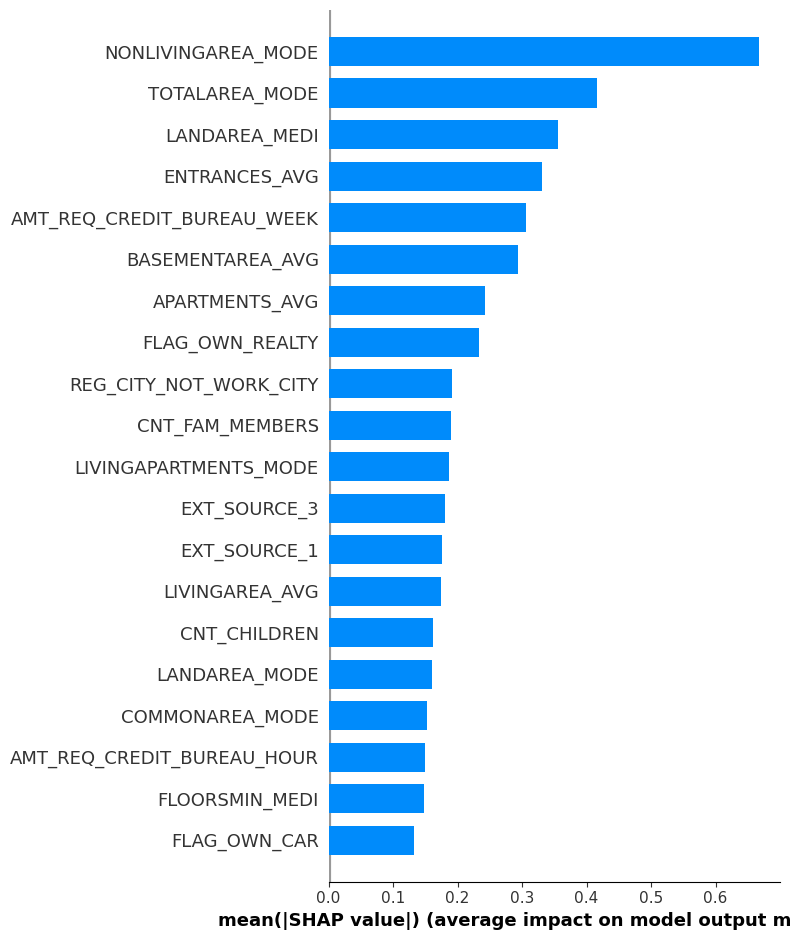

Training the model...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.1
Total Cost at Optimal Threshold: 35342


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


<Figure size 640x480 with 0 Axes>

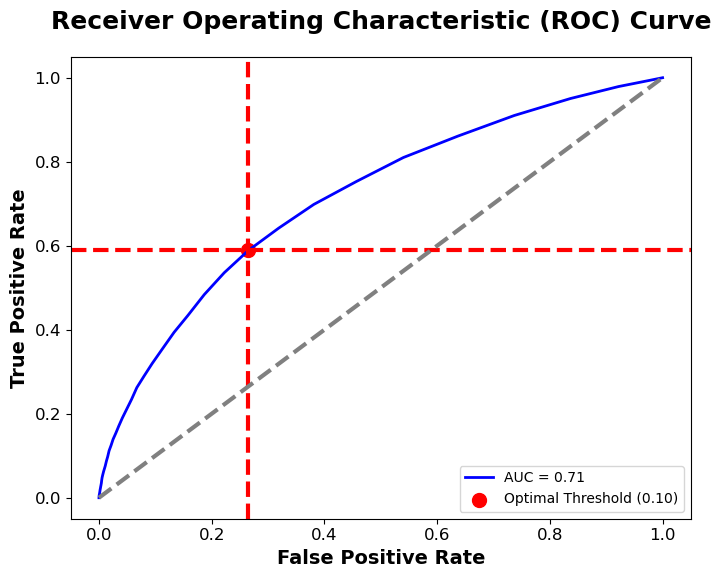

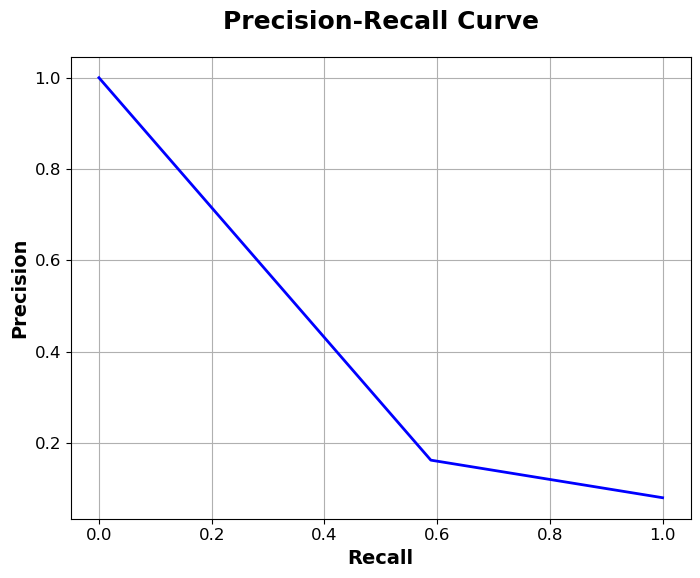

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     56554
           1       0.16      0.59      0.25      4949

    accuracy                           0.72     61503
   macro avg       0.56      0.66      0.54     61503
weighted avg       0.89      0.72      0.78     61503

Confusion Matrix:
[[41562 14992]
 [ 2035  2914]]
Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.4941856829464377
Total Cost at Optimal Threshold: 34521


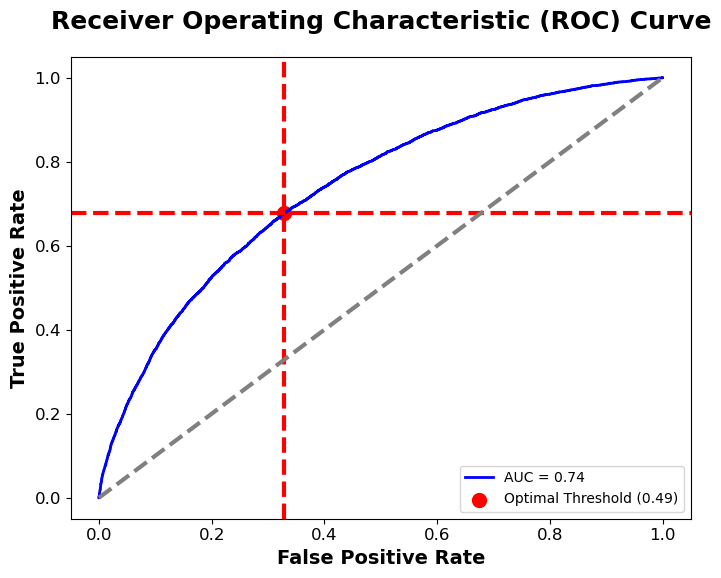

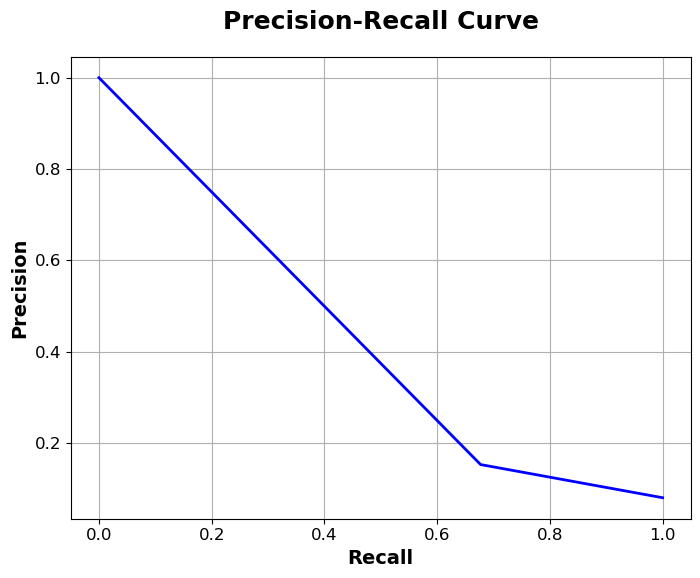

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56554
           1       0.15      0.68      0.25      4949

    accuracy                           0.67     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.67      0.75     61503

Confusion Matrix:
[[38013 18541]
 [ 1598  3351]]
Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.08338737474365533
Total Cost at Optimal Threshold: 33214


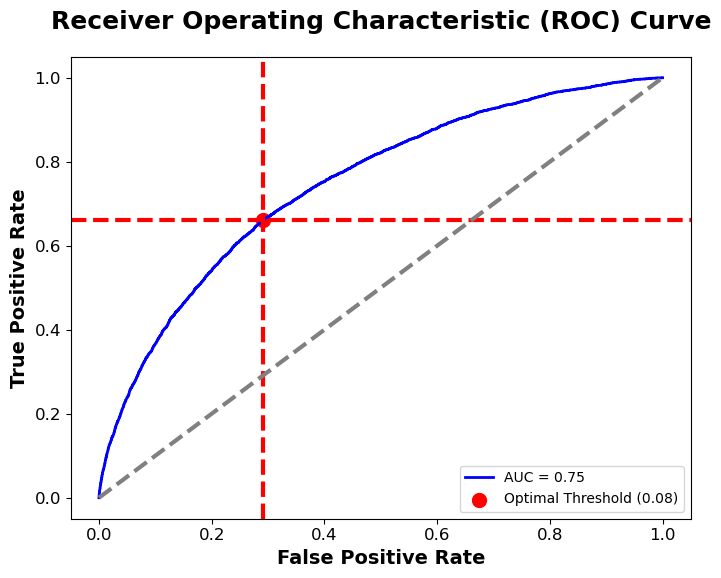

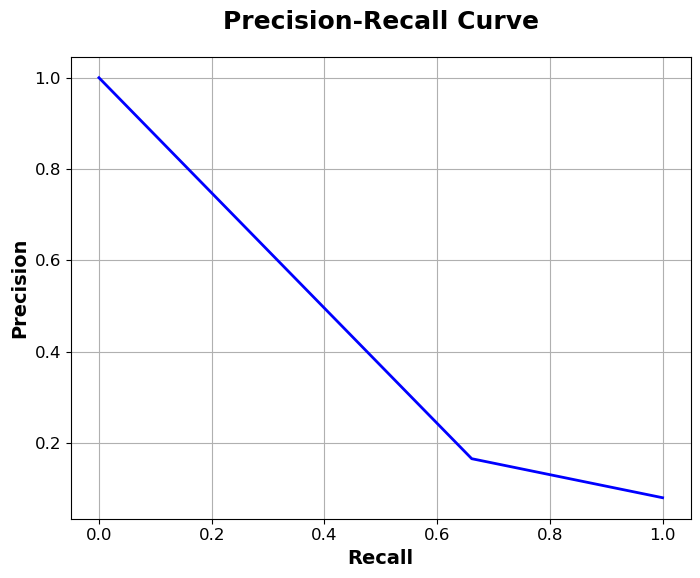

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56554
           1       0.17      0.66      0.27      4949

    accuracy                           0.71     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.71      0.77     61503

Confusion Matrix:
[[40100 16454]
 [ 1676  3273]]


In [33]:
# ==================================================================================================
# TEST 1 : DATA PROCESSING - df_application_train
# ==================================================================================================
preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train)

# ==================================================================================================
# Model 1: XGBOOST 
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"XGBOOST_test_{formatted_datetime}_TEST1"

run_mlflow_experiment(model=XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
                      experiment_name="P7_Models",
                      b_displaySHAP = True)

# ==================================================================================================
# Model 2: RANDOM FOREST CLASSIFIER
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"RANDOM_FOREST_test_{formatted_datetime}_TEST1"

run_mlflow_experiment(model= RandomForestClassifier(class_weight='balanced', verbose=1),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
                      experiment_name="P7_Models")

# ==================================================================================================
# Model 3: Logistic Regression
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"LOGISTIC_REGRESSION_test_{formatted_datetime}_TEST1"

run_mlflow_experiment(model=LogisticRegression(class_weight='balanced'),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
                      experiment_name="P7_Models")

# ==================================================================================================
# Model 4: Gradient Boosting Classifier
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"GRADIENT_BOOSTING_test_{formatted_datetime}_TEST1"

run_mlflow_experiment(model=GradientBoostingClassifier(),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train dataset (adding Feature Importance with SHAP)", 
                      experiment_name="P7_Models")

### III.1.1. FEATURE IMPORTANCE OF TEST1's BEST MODEL

## III.2. TEST 2 - df_application_train_domain

Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.483260840177536
Total Cost at Optimal Threshold: 32851


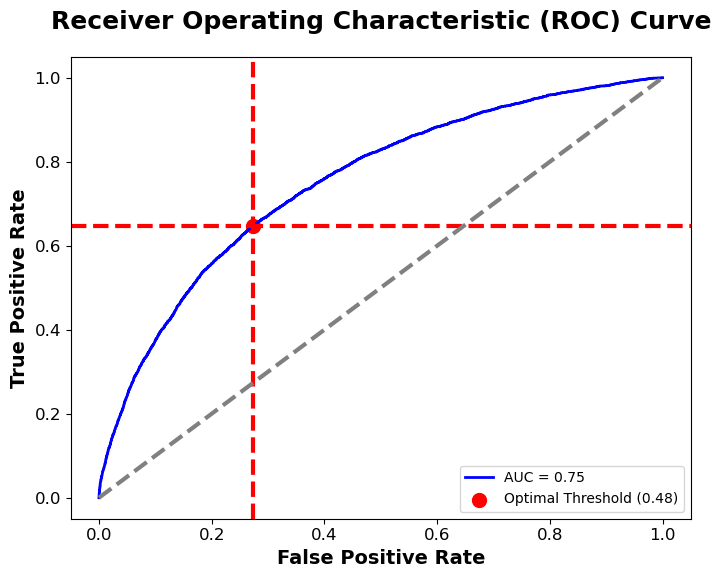

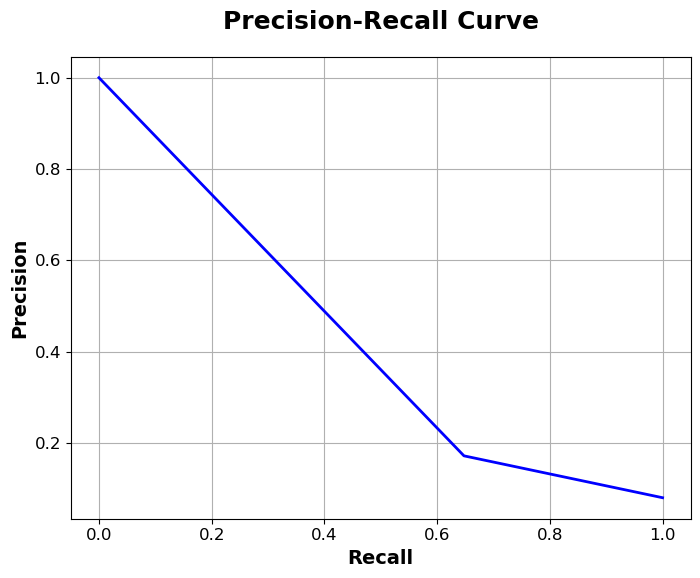

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56554
           1       0.17      0.65      0.27      4949

    accuracy                           0.72     61503
   macro avg       0.57      0.69      0.55     61503
weighted avg       0.90      0.72      0.78     61503

Confusion Matrix:
[[41143 15411]
 [ 1744  3205]]


100%|===================| 61237/61503 [01:36<00:00]        

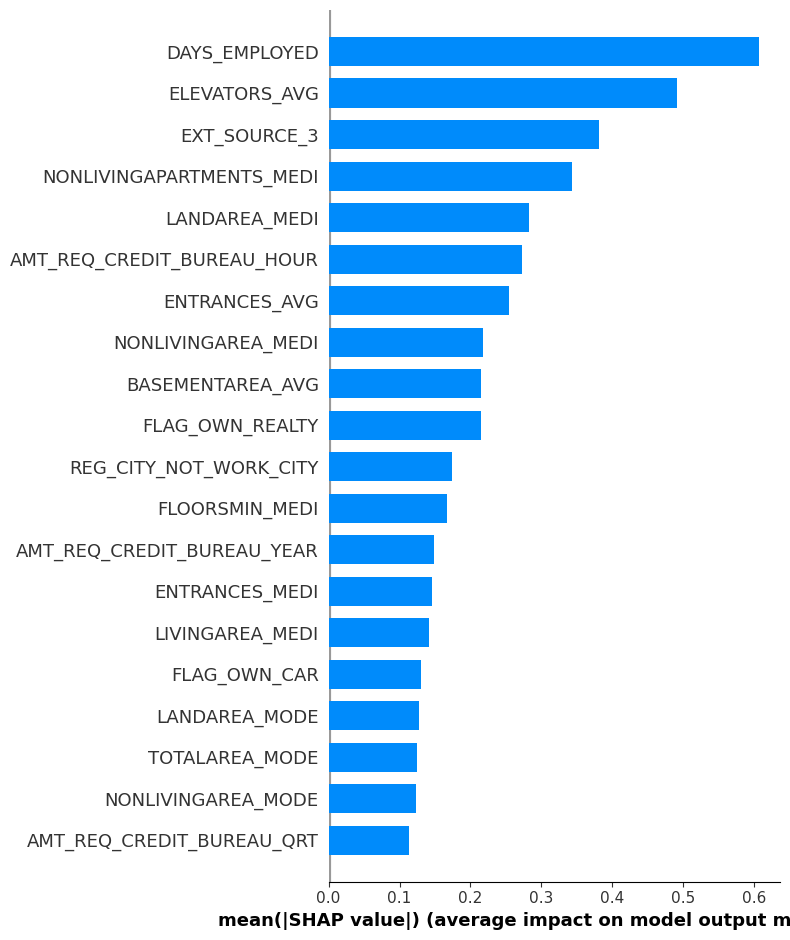

Training the model...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished


Model training completed.
Making predictions...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Predictions made.
Optimal Threshold: 0.09
Total Cost at Optimal Threshold: 35041


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


<Figure size 640x480 with 0 Axes>

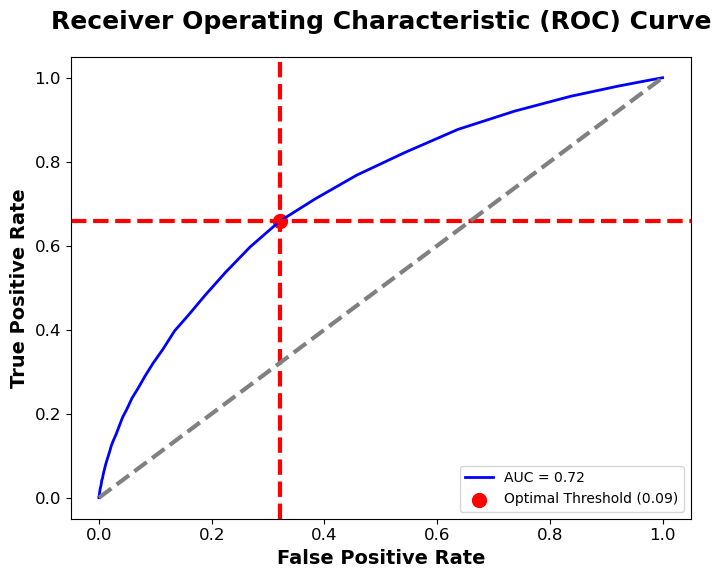

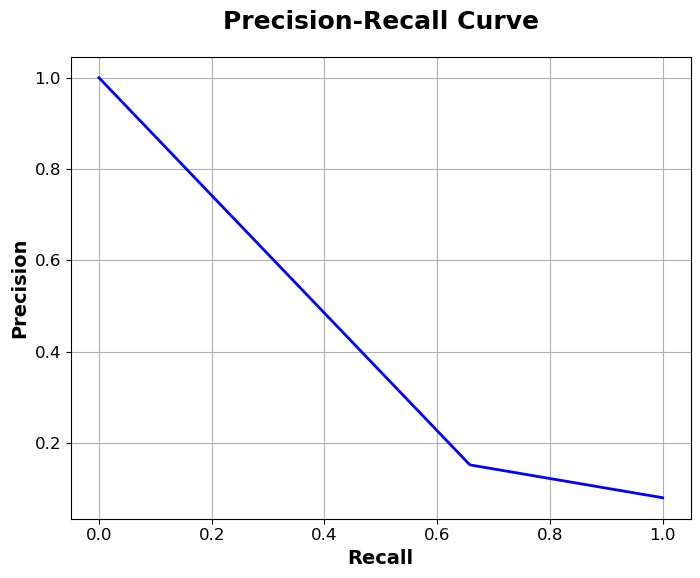

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56554
           1       0.15      0.66      0.25      4949

    accuracy                           0.68     61503
   macro avg       0.56      0.67      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Confusion Matrix:
[[38433 18121]
 [ 1692  3257]]
Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.4833649403717476
Total Cost at Optimal Threshold: 34514


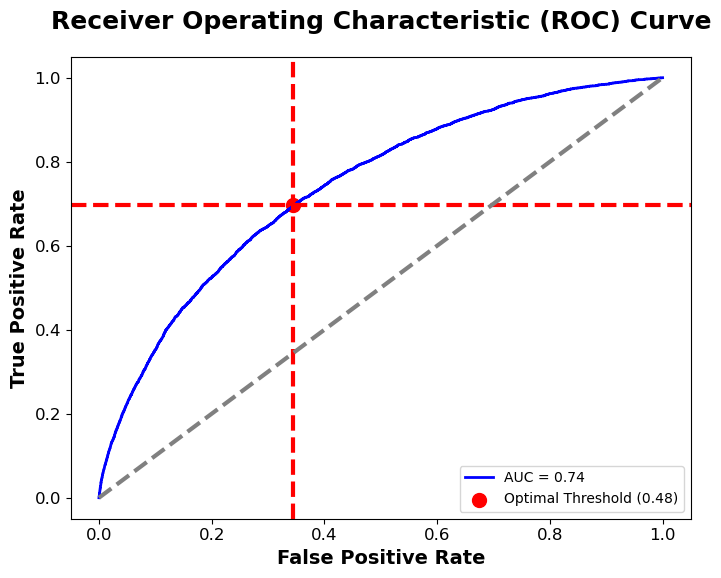

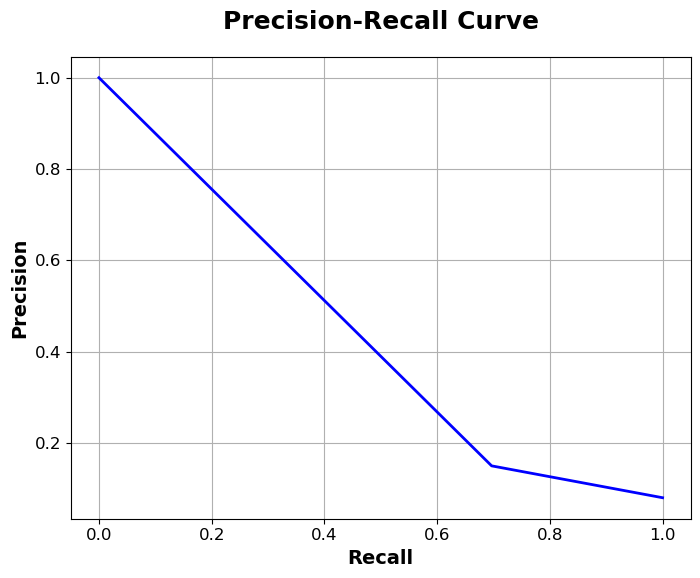

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     56554
           1       0.15      0.70      0.25      4949

    accuracy                           0.66     61503
   macro avg       0.56      0.68      0.51     61503
weighted avg       0.90      0.66      0.74     61503

Confusion Matrix:
[[37050 19504]
 [ 1501  3448]]
Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.07332137838580136
Total Cost at Optimal Threshold: 33154


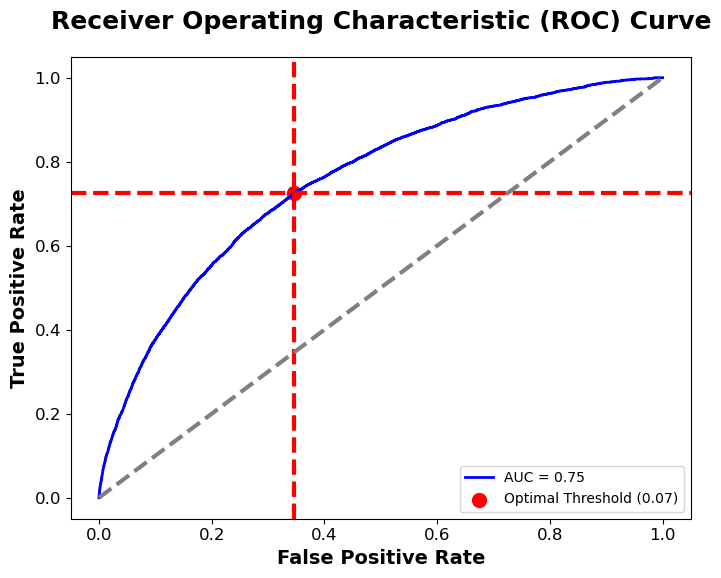

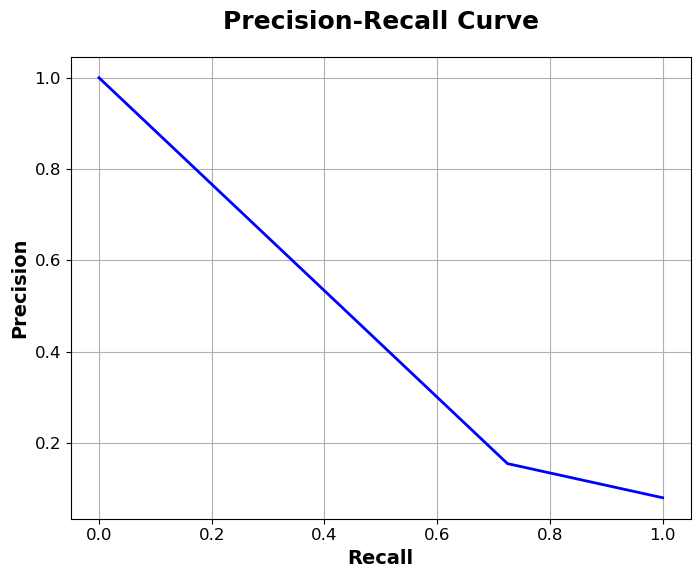

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78     56554
           1       0.16      0.72      0.26      4949

    accuracy                           0.66     61503
   macro avg       0.56      0.69      0.52     61503
weighted avg       0.90      0.66      0.74     61503

Confusion Matrix:
[[37020 19534]
 [ 1362  3587]]


In [34]:
# ==================================================================================================
# TEST 2 : DATA PROCESSING - df_application_train_domain
# ==================================================================================================
preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train_domain)

# ==================================================================================================
# Model 1: XGBOOST 
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"XGBOOST_test_{formatted_datetime}_TEST2"

run_mlflow_experiment(model=XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train_domain dataset", 
                      experiment_name="P7_Models",
                      b_displaySHAP = True)

# ==================================================================================================
# Model 2: RANDOM FOREST CLASSIFIER
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"RANDOM_FOREST_test_{formatted_datetime}_TEST2"

run_mlflow_experiment(model= RandomForestClassifier(class_weight='balanced', verbose=1),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train_domain dataset", 
                      experiment_name="P7_Models")

# ==================================================================================================
# Model 3: Logistic Regression
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"LOGISTIC_REGRESSION_test_{formatted_datetime}_TEST2"

run_mlflow_experiment(model=LogisticRegression(class_weight='balanced'),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train_domain dataset", 
                      experiment_name="P7_Models")

# ==================================================================================================
# Model 4: Gradient Boosting Classifier
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"GRADIENT_BOOSTING_test_{formatted_datetime}_TEST2"

run_mlflow_experiment(model=GradientBoostingClassifier(),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train_domain dataset", 
                      experiment_name="P7_Models")

## III.3. TEST 3 - df_application_train_poly

Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.47943100333213806
Total Cost at Optimal Threshold: 33847


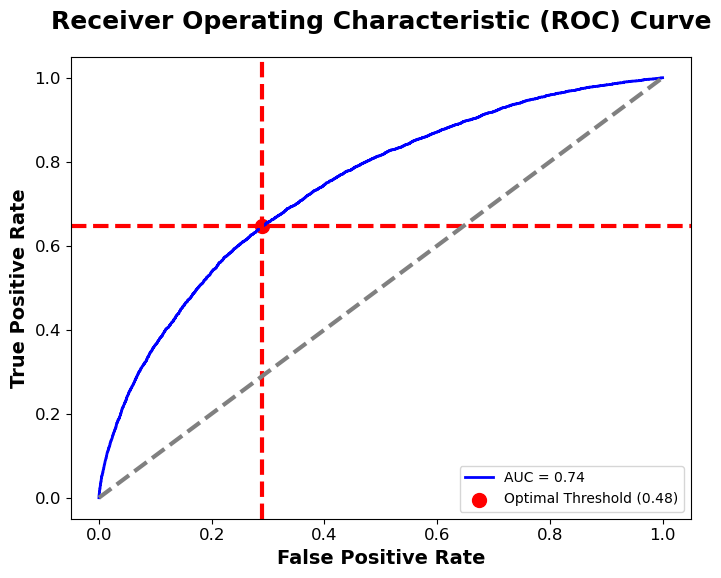

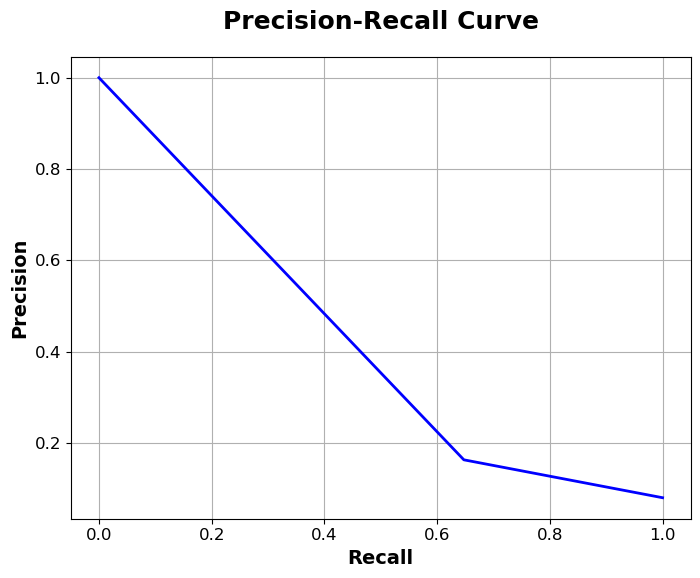

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56554
           1       0.16      0.65      0.26      4949

    accuracy                           0.71     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.89      0.71      0.77     61503

Confusion Matrix:
[[40157 16397]
 [ 1745  3204]]


100%|===================| 61435/61503 [01:28<00:00]        

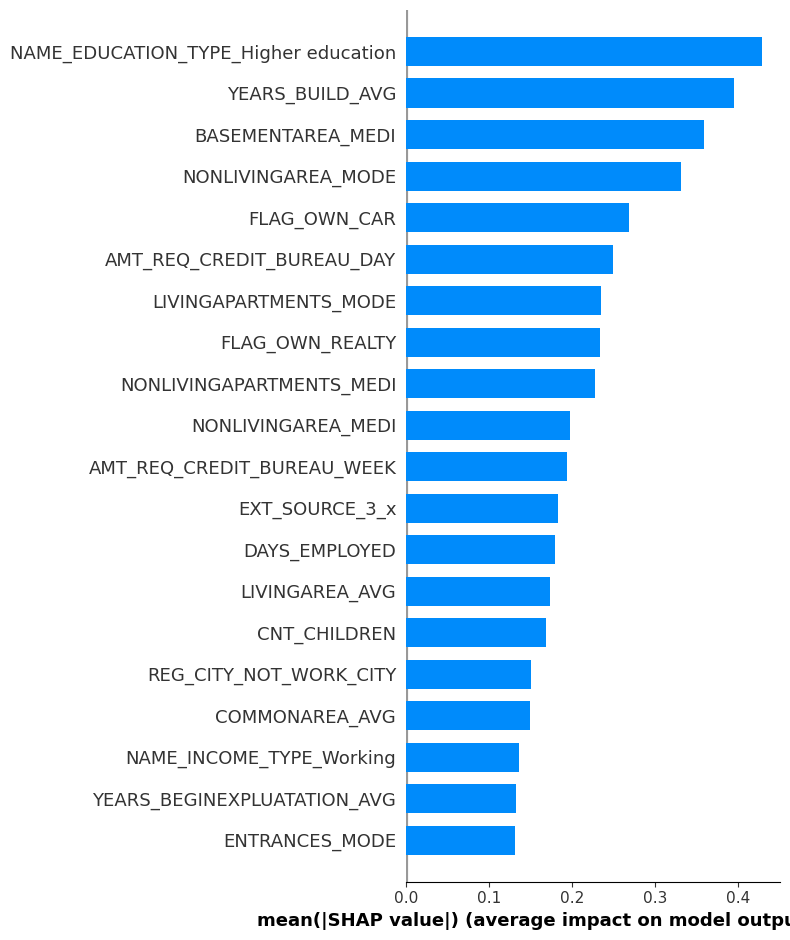

Training the model...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.7min finished


Model training completed.
Making predictions...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Predictions made.
Optimal Threshold: 0.09
Total Cost at Optimal Threshold: 36213


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


<Figure size 640x480 with 0 Axes>

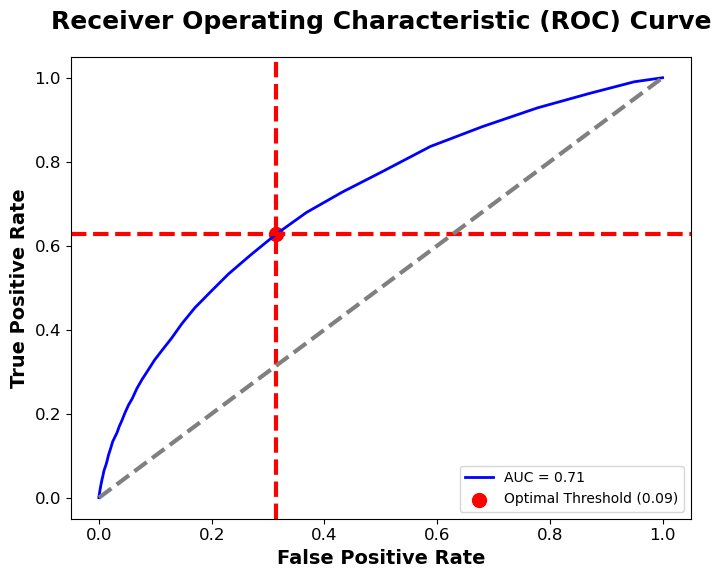

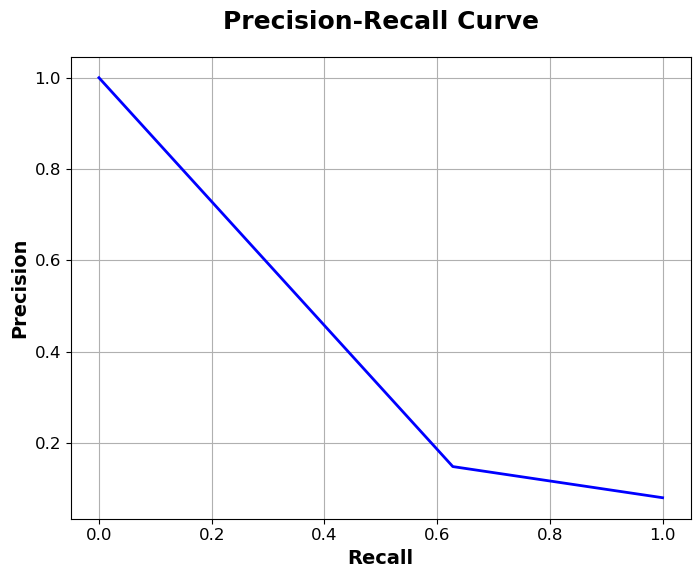

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     56554
           1       0.15      0.63      0.24      4949

    accuracy                           0.68     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.68      0.75     61503

Confusion Matrix:
[[38761 17793]
 [ 1842  3107]]
Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.5106508637851978
Total Cost at Optimal Threshold: 34037


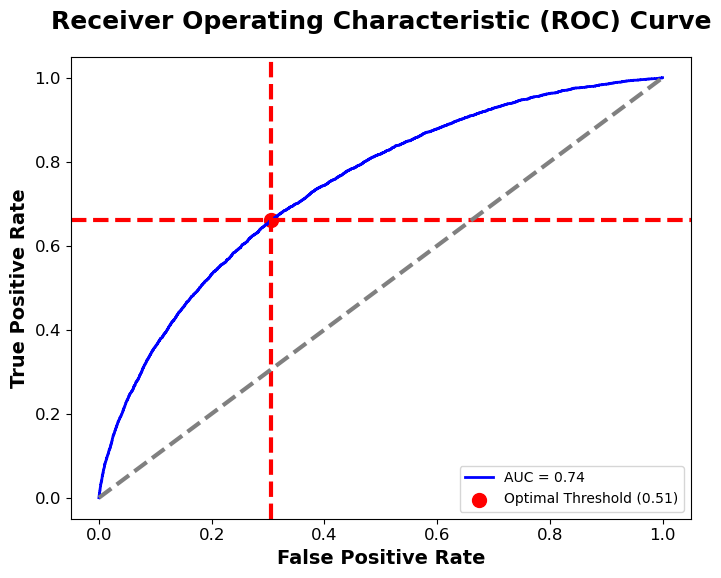

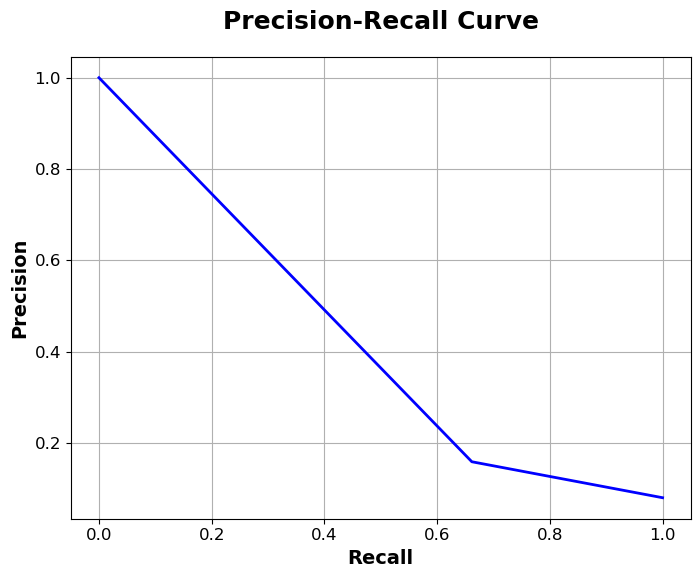

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56554
           1       0.16      0.66      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503

Confusion Matrix:
[[39267 17287]
 [ 1675  3274]]
Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.07723690663099046
Total Cost at Optimal Threshold: 33534


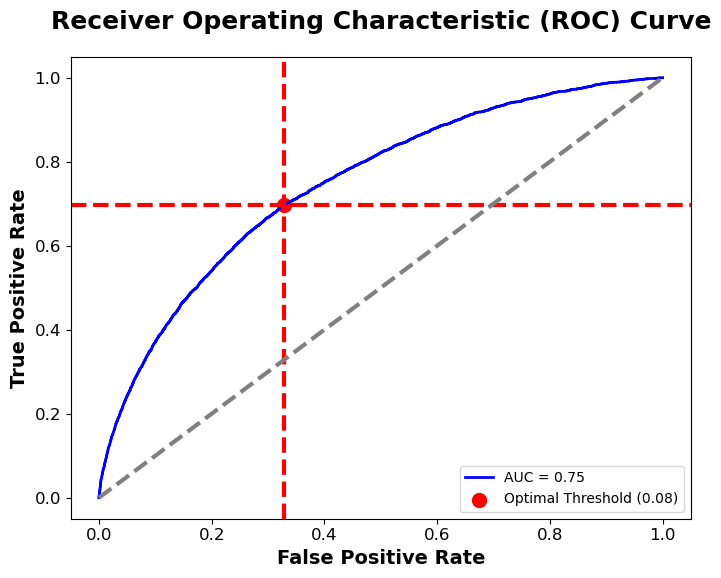

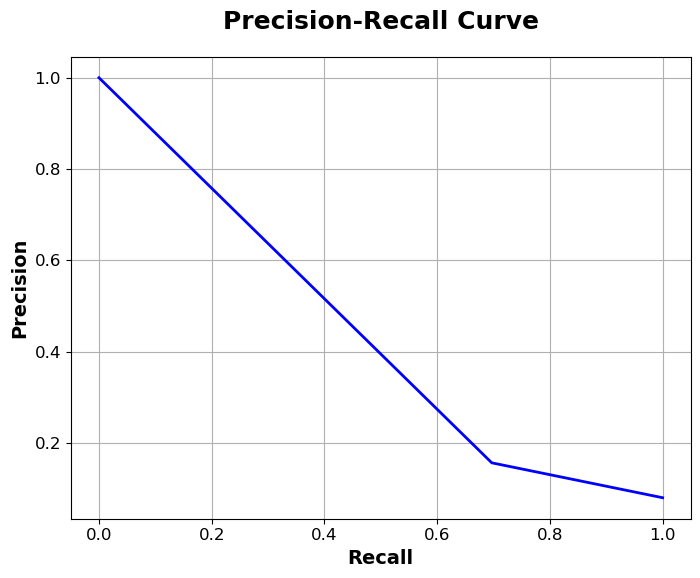

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56554
           1       0.16      0.70      0.26      4949

    accuracy                           0.67     61503
   macro avg       0.56      0.68      0.52     61503
weighted avg       0.90      0.67      0.75     61503

Confusion Matrix:
[[38020 18534]
 [ 1500  3449]]


In [35]:
# ==================================================================================================
# TEST 3 : DATA PROCESSING - df_application_train_poly
# ==================================================================================================
preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train_poly)

# ==================================================================================================
# Model 1: XGBOOST 
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"XGBOOST_test_{formatted_datetime}_TEST3"

run_mlflow_experiment(model=XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train_poly dataset", 
                      experiment_name="P7_Models",
                      b_displaySHAP = True)

# ==================================================================================================
# Model 2: RANDOM FOREST CLASSIFIER
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"RANDOM_FOREST_test_{formatted_datetime}_TEST3"

run_mlflow_experiment(model= RandomForestClassifier(class_weight='balanced', verbose=1),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train_poly dataset", 
                      experiment_name="P7_Models")

# ==================================================================================================
# Model 3: Logistic Regression
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"LOGISTIC_REGRESSION_test_{formatted_datetime}_TEST3"

run_mlflow_experiment(model=LogisticRegression(class_weight='balanced'),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train_poly dataset", 
                      experiment_name="P7_Models")

# ==================================================================================================
# Model 4: Gradient Boosting Classifier
# ==================================================================================================
# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"GRADIENT_BOOSTING_test_{formatted_datetime}_TEST3"

run_mlflow_experiment(model=GradientBoostingClassifier(),
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "MODEL on df_application_train_poly dataset", 
                      experiment_name="P7_Models")

## III.4. TEST 4 - HYPERPARAMETER TUNING OF THE BEST MODEL AND BEST DATASET

In [36]:
# from sklearn.model_selection import GridSearchCV
# # ==================================================================================================
# # TEST 4 : DATA PROCESSING - df_application_train_poly
# # ==================================================================================================
# preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train_domain)

# # Step 2: Define the XGBoost model
# xgb_model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())

# # Step 3: Define the parameter grid for hyperparameter tuning
# param_grid_xgb = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'reg_alpha': [0, 0.1, 0.5, 1],
#     'reg_lambda': [0, 0.1, 0.5, 1]
# }

# # Step 4: Use GridSearchCV to search for the best hyperparameters
# grid_search_xgb = GridSearchCV(estimator=xgb_model,
#                                param_grid=param_grid_xgb,
#                                scoring='roc_auc',
#                                cv=3,
#                                verbose=2)

# grid_search_xgb.fit(X_train, y_train)

# # Step 5: Extract the best model from the GridSearchCV results
# best_xgb_model = grid_search_xgb.best_estimator_

# # Step 6: Evaluate and log the best model using your global function
# # Get the current date and time and format it
# formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
# run_name = f"XGBOOST_HYPERPARAMETER_TUNING_test_{formatted_datetime}_TEST4"

# run_mlflow_experiment(model=best_xgb_model,
#                       preprocessor=preprocessor,
#                       X_train=X_train, y_train=y_train,
#                       X_test=X_test, y_test=y_test,
#                       run_name=run_name,
#                       description="Hyperparameter tuning of XGBoost model on df_application_train_domain dataset",
#                       experiment_name="P7_Models")



In [37]:
# # Display some statistics about the best model
# print("Best Model Statistics:")
# print("Best Estimator:", grid_search_xgb.best_estimator_)
# print("Best Parameters:", grid_search_xgb.best_params_)
# print("Best AUC-ROC Score:", grid_search_xgb.best_score_)

## III.3. TEST 4 (BIS) - Best MODEL (which is already tuned)

Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.48960351943969727
Total Cost at Optimal Threshold: 32571


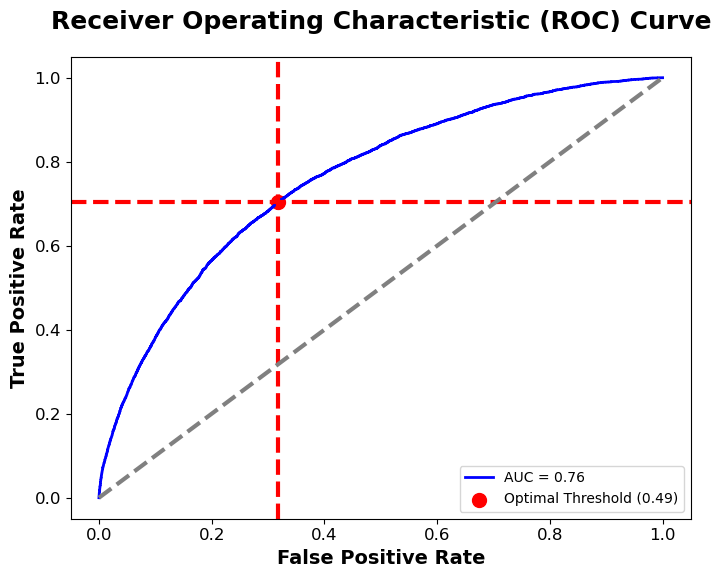

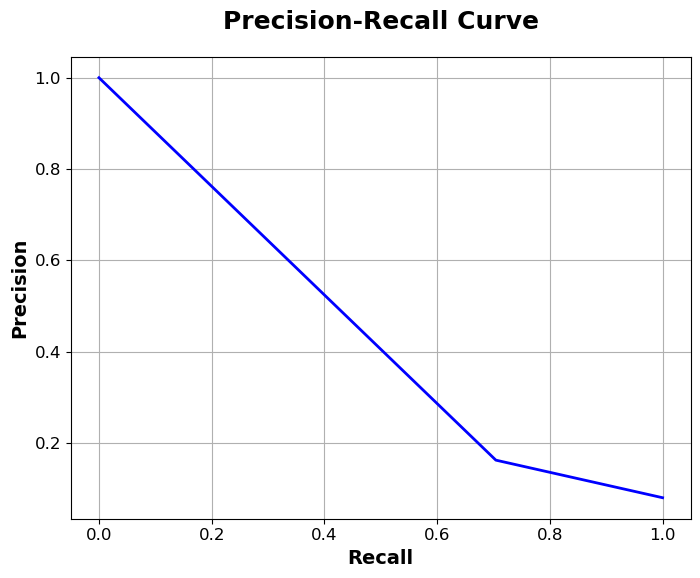

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56554
           1       0.16      0.70      0.26      4949

    accuracy                           0.68     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.68      0.76     61503

Confusion Matrix:
[[38623 17931]
 [ 1464  3485]]


 99%|===================| 61123/61503 [01:27<00:00]        

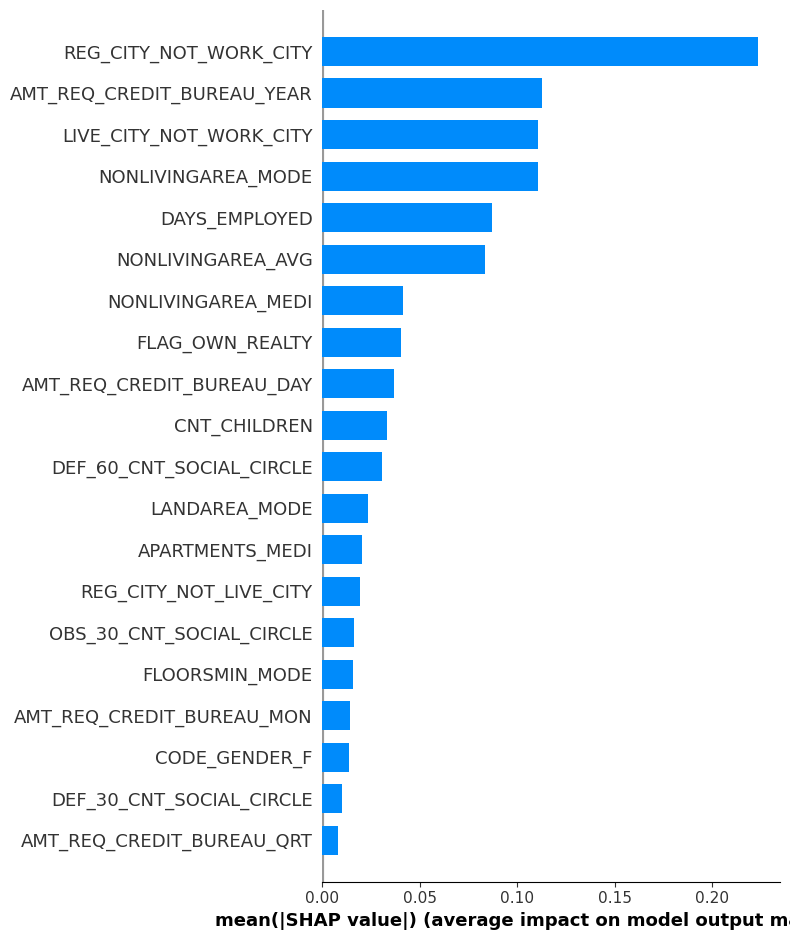

<Figure size 640x480 with 0 Axes>

In [38]:
# ==================================================================================================
# TEST 4 : DATA PROCESSING - df_application_train_domain
# ==================================================================================================
preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train_domain)


# Get the best parameters from the grid search results
# best_params = grid_search_xgb.best_params_

# Define the best parameters
best_params_hardcoded = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1}

# Extract the best hyperparameters
best_learning_rate = best_params_hardcoded['learning_rate']
best_max_depth = best_params_hardcoded['max_depth']
best_n_estimators = best_params_hardcoded['n_estimators']
best_reg_alpha = best_params_hardcoded['reg_alpha']
best_reg_lambda = best_params_hardcoded['reg_lambda']
# ==================================================================================================
# Model 1: XGBOOST 
# ==================================================================================================
# Create XGBoost model with the best hyperparameters
best_xgb_model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                               learning_rate=best_learning_rate,
                               max_depth=best_max_depth,
                               n_estimators=best_n_estimators,
                               reg_alpha=best_reg_alpha,
                               reg_lambda=best_reg_lambda)


# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"XGBOOST_test_{formatted_datetime}_TEST3"

run_mlflow_experiment(model=best_xgb_model,
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "TUNED MODEL on df_application_train_domain dataset", 
                      experiment_name="P7_Models",
                      b_displaySHAP = True)



# IV. FEATURE ENGINEERING USING CHATGPT

In [39]:
import pandas as pd
df_application_train_chatGPT = df_application_train.copy()
# 1. Debt-to-Income Ratio (DTI)
df_application_train_chatGPT['DTI'] = df_application_train_chatGPT['AMT_INCOME_TOTAL'] / df_application_train_chatGPT['AMT_ANNUITY']

# 2. Credit Utilization Ratio
df_application_train_chatGPT['Credit_Utilization_Ratio'] = df_application_train_chatGPT['AMT_CREDIT'] / df_application_train_chatGPT['AMT_INCOME_TOTAL']

# 3. Length of Employment (in years)
df_application_train_chatGPT['Length_of_Employment_years'] = -df_application_train_chatGPT['DAYS_EMPLOYED'] / 365

# 4. Age at Application
df_application_train_chatGPT['Age_at_Application'] = -df_application_train_chatGPT['DAYS_BIRTH'] / 365

# 5. Number of Dependents per Income
df_application_train_chatGPT['Dependents_per_Income'] = df_application_train_chatGPT['CNT_CHILDREN'] / df_application_train_chatGPT['AMT_INCOME_TOTAL']

# 6. Income Stability
# You can compute this based on variations in income amounts or frequency of income changes. 
# For simplicity, let's assume Income Stability as the standard deviation of income over the last 12 months.
df_application_train_chatGPT['Income_Stability'] = df_application_train_chatGPT.groupby('SK_ID_CURR')['AMT_INCOME_TOTAL'].transform(lambda x: x.rolling(window=12).std())

# 7. Credit History Length
# You can compute this based on the difference between the earliest and latest credit application dates.
df_application_train_chatGPT['Credit_History_Length'] = df_application_train_chatGPT['DAYS_ID_PUBLISH'] - df_application_train_chatGPT['DAYS_REGISTRATION']

# 8. Payment History
# You can analyze this based on the number of late payments or defaults on previous loans.
# For simplicity, let's assume Payment History as the sum of OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE.
df_application_train_chatGPT['Payment_History'] = df_application_train_chatGPT['OBS_30_CNT_SOCIAL_CIRCLE'] + df_application_train_chatGPT['OBS_60_CNT_SOCIAL_CIRCLE']

# 9. Property Ownership Status
# Let's create a binary feature indicating whether the client owns a property.
df_application_train_chatGPT['Property_Ownership'] = df_application_train_chatGPT['FLAG_OWN_REALTY']

# 10. Number of Credit Inquiries
# Let's count the number of recent credit inquiries made by the client.
df_application_train_chatGPT['Credit_Inquiries'] = df_application_train_chatGPT[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
                                 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                                 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)

# Age at Application: Calculate the age of the applicant at the time of application using the DAYS_BIRTH feature
# Convert DAYS_BIRTH to years and subtract from the current year
df_application_train_chatGPT['AGE_AT_APPLICATION'] = round(-df_application_train_chatGPT['DAYS_BIRTH'] / 365, 2)

# Years Employed: Calculate the number of years the applicant has been employed using the DAYS_EMPLOYED feature.
# Convert DAYS_EMPLOYED to years
df_application_train_chatGPT['YEARS_EMPLOYED'] = round(-df_application_train_chatGPT['DAYS_EMPLOYED'] / 365, 2)

# Income per Family Member: Calculate the income per family member using the AMT_INCOME_TOTAL and CNT_FAM_MEMBERS features.
df_application_train_chatGPT['INCOME_PER_MEMBER'] = df_application_train_chatGPT['AMT_INCOME_TOTAL'] / df_application_train_chatGPT['CNT_FAM_MEMBERS']

# Credit to Income Ratio: Calculate the ratio of the credit amount to the applicant's income.
df_application_train_chatGPT['CREDIT_INCOME_RATIO'] = df_application_train_chatGPT['AMT_CREDIT'] / df_application_train_chatGPT['AMT_INCOME_TOTAL']


# Annuity to Income Ratio: Calculate the ratio of the loan annuity to the applicant's income.
df_application_train_chatGPT['ANNUNITY_INCOME_RATIO'] = df_application_train_chatGPT['AMT_ANNUITY'] / df_application_train_chatGPT['AMT_INCOME_TOTAL']


# Length of Employment in Years: Calculate the length of employment in years based on DAYS_EMPLOYED.
df_application_train_chatGPT['EMPLOYMENT_LENGTH_YEARS'] = round(-df_application_train_chatGPT['DAYS_EMPLOYED'] / 365, 2)

# Number of Documents Submitted: Sum up the binary document flags to get the total number of documents submitted.
document_flags = [col for col in df_application_train_chatGPT.columns if 'FLAG_DOCUMENT' in col]
df_application_train_chatGPT['NUM_DOCUMENTS_SUBMITTED'] = df_application_train_chatGPT[document_flags].sum(axis=1)


# Display the updated dataframe with new features
display(df_application_train_chatGPT.head())


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATIO

## IV.1. TEST 5 - Best MODEL using CHATGPT FEATURE ENGINEERING

Training the model...
Model training completed.
Making predictions...
Predictions made.
Optimal Threshold: 0.4989781975746155
Total Cost at Optimal Threshold: 32930


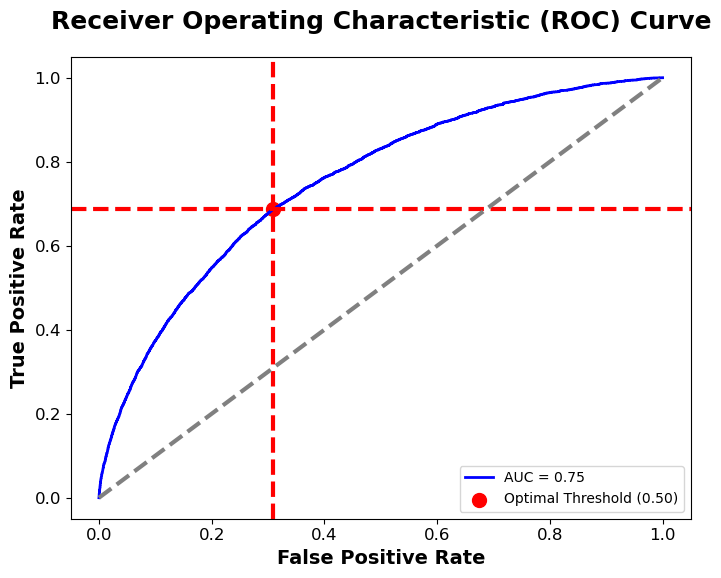

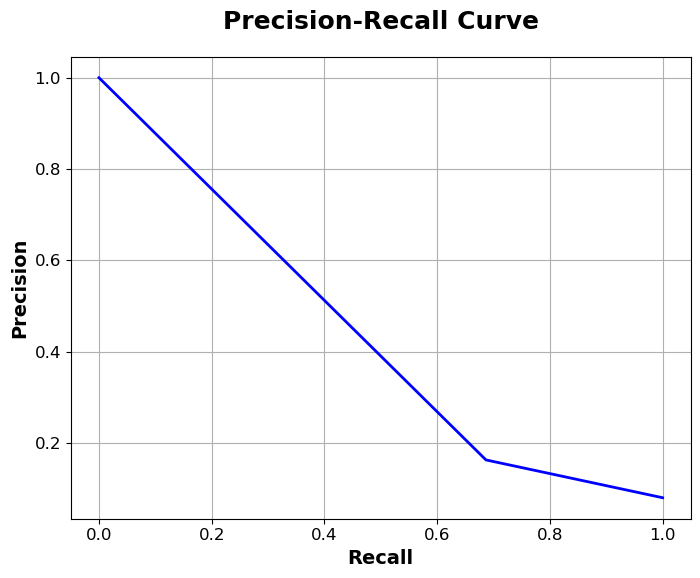

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56554
           1       0.16      0.69      0.26      4949

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503

Confusion Matrix:
[[39134 17420]
 [ 1551  3398]]


 99%|===================| 60779/61503 [01:22<00:00]        

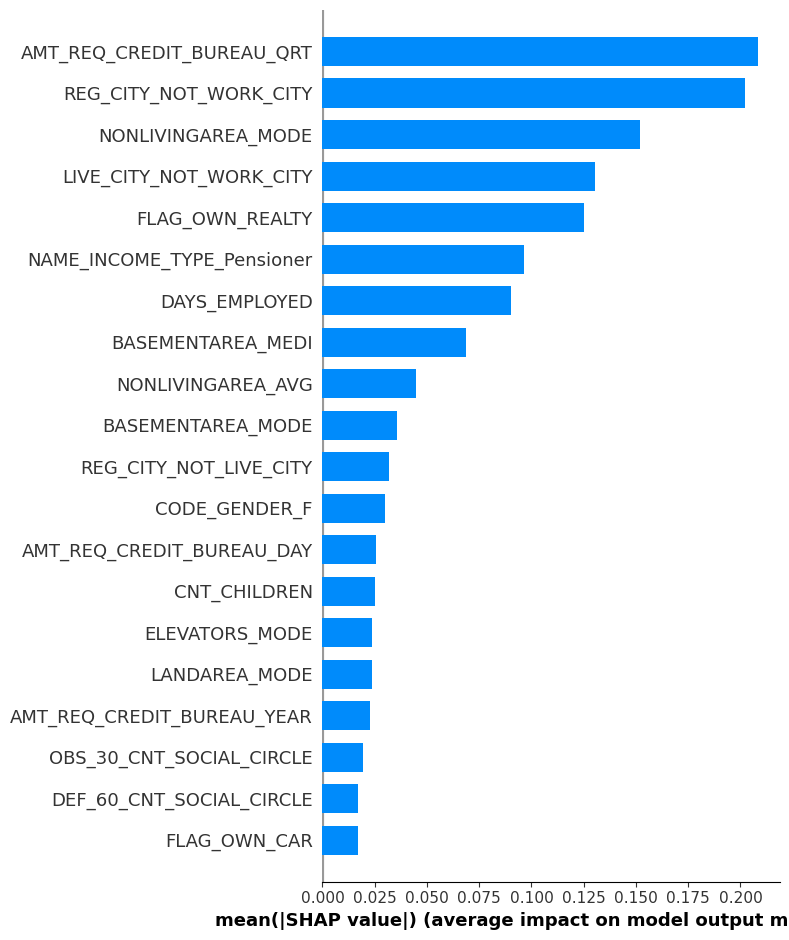

<Figure size 640x480 with 0 Axes>

In [40]:
# ==================================================================================================
# TEST 5 : DATA PROCESSING - df_application_train_chatGPT
# ==================================================================================================
preprocessor, X_train, y_train, X_test, y_test = preprocess_dataframe(df_application_train_chatGPT)


# Get the best parameters from the grid search results
# best_params = grid_search_xgb.best_params_

# Define the best parameters
best_params_hardcoded = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1}

# Extract the best hyperparameters
best_learning_rate = best_params_hardcoded['learning_rate']
best_max_depth = best_params_hardcoded['max_depth']
best_n_estimators = best_params_hardcoded['n_estimators']
best_reg_alpha = best_params_hardcoded['reg_alpha']
best_reg_lambda = best_params_hardcoded['reg_lambda']
# ==================================================================================================
# Model 1: XGBOOST 
# ==================================================================================================
# Create XGBoost model with the best hyperparameters
best_xgb_model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                               learning_rate=best_learning_rate,
                               max_depth=best_max_depth,
                               n_estimators=best_n_estimators,
                               reg_alpha=best_reg_alpha,
                               reg_lambda=best_reg_lambda)


# Get the current date and time and format it
formatted_datetime = datetime.now().strftime("%Y_%m_%d_%H_%M")
run_name = f"XGBOOST_tuned_{formatted_datetime}_TEST5"

run_mlflow_experiment(model=best_xgb_model,
                      preprocessor=preprocessor,
                      X_train=X_train, y_train=y_train,
                      X_test=X_test, y_test=y_test,
                      run_name=run_name,
                      description = "TUNED MODEL on df_application_train_chatGPT dataset", 
                      experiment_name="P7_Models",
                      b_displaySHAP = True)

